#Temperature Forecasting using LSTM

## Dataset and problem
Weather timeseries dataset for weather in Jena (Germany): http://www.bgc-jena.mpg.de/wetter/.

14 different quantities: air temperature, atmospheric pressure, humidity, wind direction, etc. are recorded every ten minutes, over several years. We select data from 2009-2016. We develope a model that predicts the air temperature 24 hours in the future

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import pandas as pd
import glob
import numpy as np
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

path = r'/content/gdrive/My Drive/models' # use your path
all_files = glob.glob(path + "/*.csv")

li = []
for filename in all_files:
    df = pd.read_csv(filename,  sep=',', encoding='latin-1', index_col=None, header=0)
    li.append(df)

data_df = pd.concat(li, axis=0, ignore_index=True)
data_df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


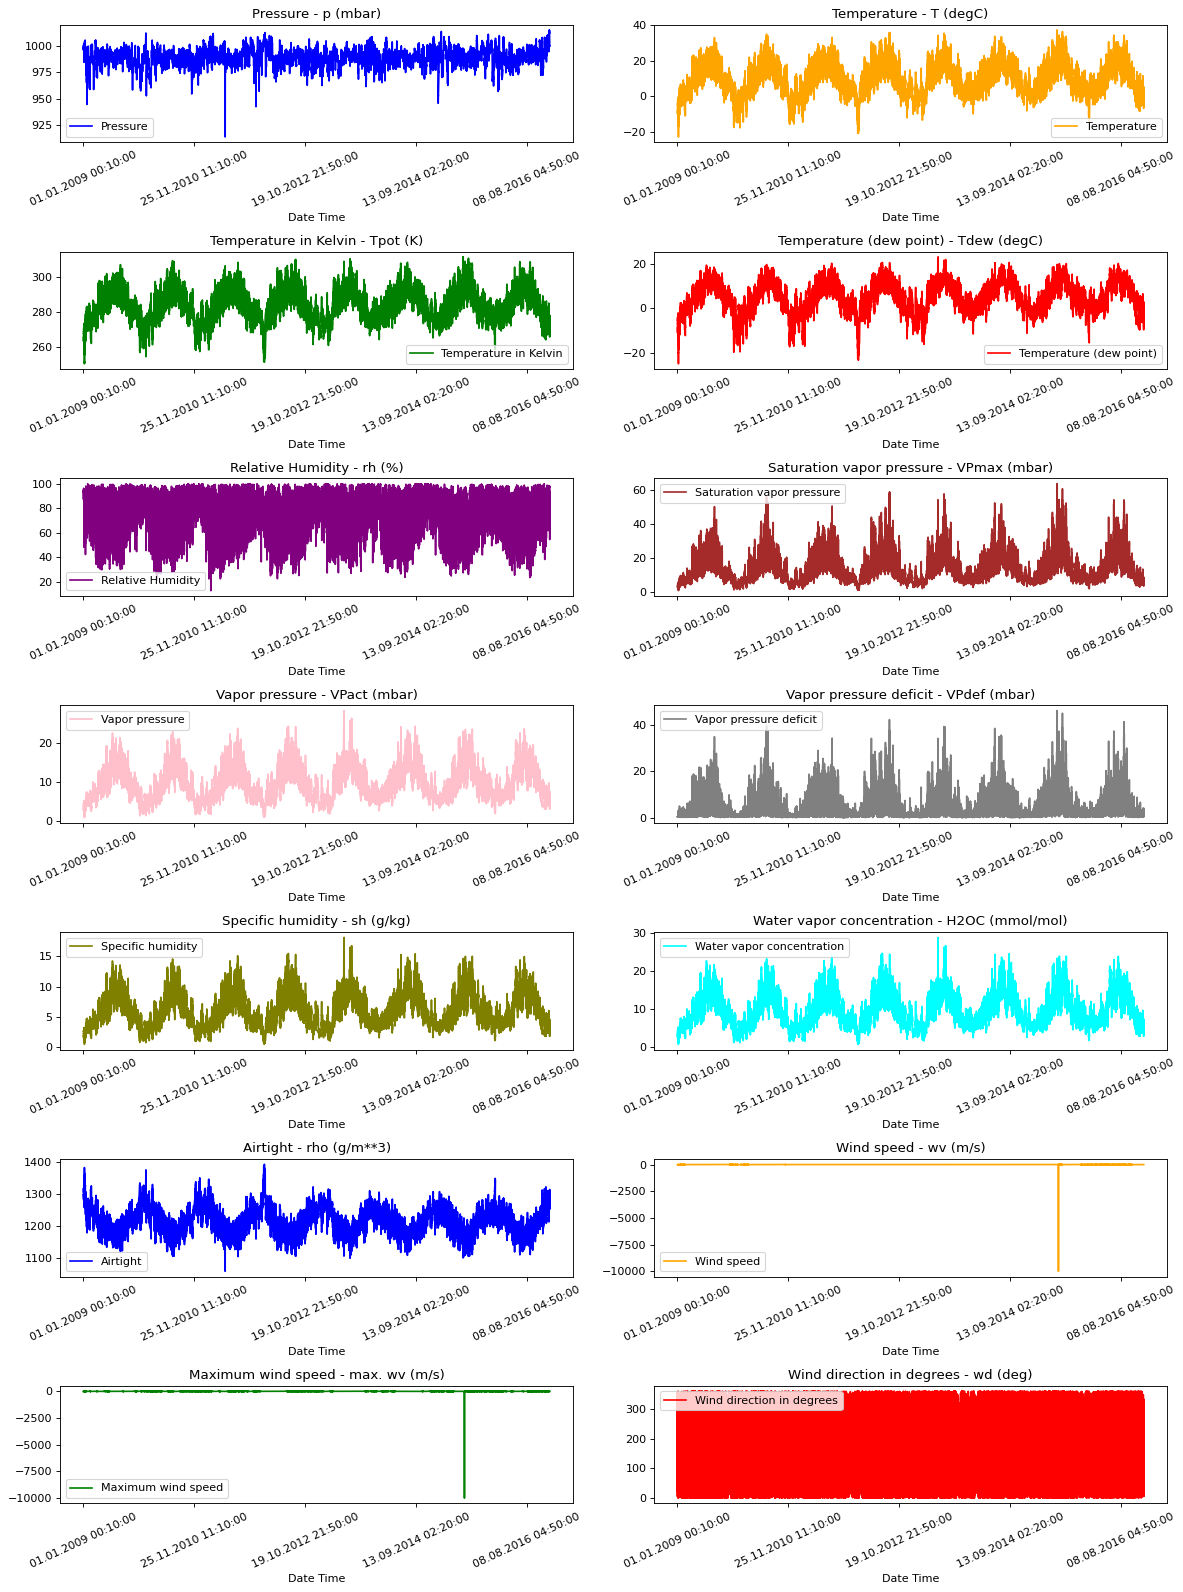

In [3]:
titles = [
    "Pressure",
    "Temperature",
    "Temperature in Kelvin",
    "Temperature (dew point)",
    "Relative Humidity",
    "Saturation vapor pressure",
    "Vapor pressure",
    "Vapor pressure deficit",
    "Specific humidity",
    "Water vapor concentration",
    "Airtight",
    "Wind speed",
    "Maximum wind speed",
    "Wind direction in degrees",
]

feature_keys = [
    "p (mbar)",
    "T (degC)",
    "Tpot (K)",
    "Tdew (degC)",
    "rh (%)",
    "VPmax (mbar)",
    "VPact (mbar)",
    "VPdef (mbar)",
    "sh (g/kg)",
    "H2OC (mmol/mol)",
    "rho (g/m**3)",
    "wv (m/s)",
    "max. wv (m/s)",
    "wd (deg)",
]

colors = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]

date_time_key = "Date Time"


def show_raw_visualization(data):
    time_data = data[date_time_key]
    fig, axes = plt.subplots(
        nrows=7, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(feature_keys)):
        key = feature_keys[i]
        c = colors[i % (len(colors))]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{} - {}".format(titles[i], key),
            rot=25,
        )
        ax.legend([titles[i]])
    plt.tight_layout()


show_raw_visualization(data_df)

<ipython-input-4-1ff01399364e>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  plt.matshow(data.corr())


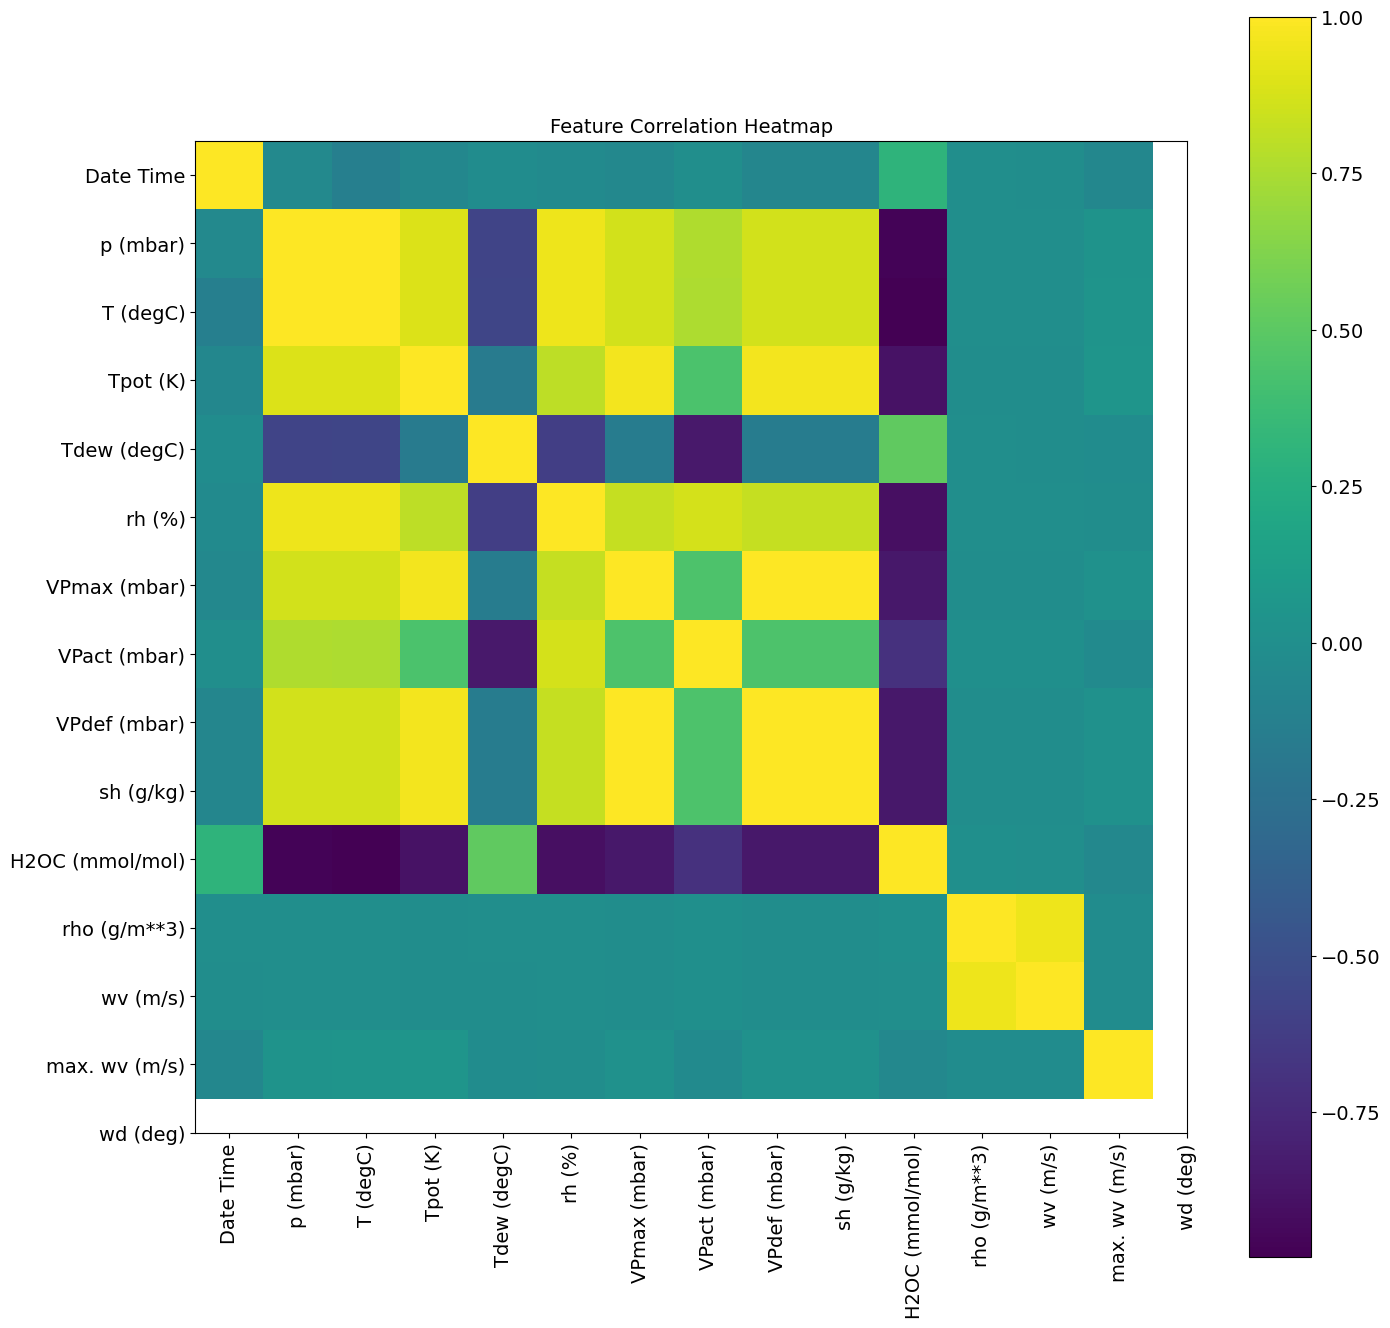

In [4]:
def show_heatmap(data):
    plt.rcParams["figure.figsize"] = (30,20)
    plt.matshow(data.corr())
    plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(range(data.shape[1]), data.columns, fontsize=14)

    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title("Feature Correlation Heatmap", fontsize=14)
    plt.show()

show_heatmap(df)

Given that observation is measured every 10 min, we may do resampling once each hour using just 1 data point per hour. We use the data from past 5 days (720 timestamps/6=120 hours=5 days), and predict the temperature after 12 hours (72 timestamps/6=12 hours). The temperature next 12 hours, or 72 observations, is used as a label.

Normalizing data

In [5]:
split_fraction = 0.8
train_split = int(split_fraction * int(df.shape[0]))
step = 6

past = 720
future = 72
learning_rate = 0.001
batch_size = 256
epochs = 20


def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std

We can see from the correlation heatmap, few parameters like Relative Humidity and Specific Humidity are redundant. Hence we will be using select features, not all.

In [6]:
print(
    "The selected parameters are:",
    ", ".join([titles[i] for i in [0, 1, 5, 7, 8, 10, 11]]),
)
selected_features = [feature_keys[i] for i in [0, 1, 5, 7, 8, 10, 11]]

features = data_df[selected_features]
features.index = data_df[date_time_key]
features.head()

features = normalize(features.values, train_split)
features = pd.DataFrame(features)
features.head()

The selected parameters are: Pressure, Temperature, Saturation vapor pressure, Vapor pressure deficit, Specific humidity, Airtight, Wind speed


,0,1,2,3,4,5,6
0,0.920682,-2.014960,-1.315987,-0.782129,-1.493220,2.243871,-0.727998
1,0.926670,-2.061164,-1.329360,-0.784270,-1.512196,2.294955,-0.929488
2,0.921879,-2.073012,-1.332035,-0.786410,-1.515992,2.305920,-1.273970
3,0.919484,-2.049317,-1.325348,-0.788551,-1.500811,2.279754,-1.176475
4,0.919484,-2.044578,-1.324011,-0.788551,-1.500811,2.275020,-1.189475


Splitting data: The training dataset labels starts from the 792nd observation (720 + 72).

In [7]:
train_data = features.loc[0 : train_split - 1]
val_data = features.loc[train_split:]

The timeseries_dataset_from_array function takes in a sequence of data-points gathered at equal intervals, along with time series parameters such as length of the sequences/windows, spacing between two sequence/windows, etc., to produce batches of sub-timeseries inputs and targets sampled from the main time series.

In [8]:
start = past + future
end = start + train_split

x_train = train_data[[i for i in range(7)]].values
y_train = features.iloc[start:end][[1]]

sequence_length = int(past / step)

dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

The validation dataset must not contain the last 792 rows as we won't have label data for those records, hence 792 must be subtracted from the end of the data.

The validation label dataset must start from 792 after train_split, hence we must add past + future (792) to label_start.

In [9]:
x_end = len(val_data) - past - future

label_start = train_split + past + future

x_val = val_data.iloc[:x_end][[i for i in range(7)]].values
y_val = features.iloc[label_start:][[1]]

dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (256, 120, 7)
Target shape: (256, 1)


The input shape is the above-defined batch_size, the sequence length (120 hours), and the 7 selected features.

#Build and train the LSTM model

In [20]:
nodes_values = [32, 64, 128, 256]
dropouts = [0.2, 0.4, 0.6]
epochs = 10

In [21]:
dataset_test = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sequence_stride=int(sequence_length * 6),
    sampling_rate=step,
    batch_size=1,
)

In [22]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    print("Final val loss: ", val_loss)

Epoch 1/10
1312/1312 [==============================] - 17s 11ms/step - loss: 0.2092 - val_loss: 0.1861
Epoch 2/10
1312/1312 [==============================] - 14s 11ms/step - loss: 0.1462 - val_loss: 0.1786
Epoch 3/10
1312/1312 [==============================] - 15s 11ms/step - loss: 0.1359 - val_loss: 0.1781
Epoch 4/10
1312/1312 [==============================] - 14s 11ms/step - loss: 0.1323 - val_loss: 0.1734
Epoch 5/10
1312/1312 [==============================] - 15s 11ms/step - loss: 0.1281 - val_loss: 0.1731
Epoch 6/10
1312/1312 [==============================] - 14s 11ms/step - loss: 0.1262 - val_loss: 0.1650
Epoch 7/10
1312/1312 [==============================] - 14s 11ms/step - loss: 0.1240 - val_loss: 0.1612
Epoch 8/10
1312/1312 [==============================] - 15s 11ms/step - loss: 0.1224 - val_loss: 0.1515
Epoch 9/10
1312/1312 [==============================] - 15s 11ms/step - loss: 0.1213 - val_loss: 0.1482
Epoch 10/10
1312/1312 [==============================] - 15s 11m

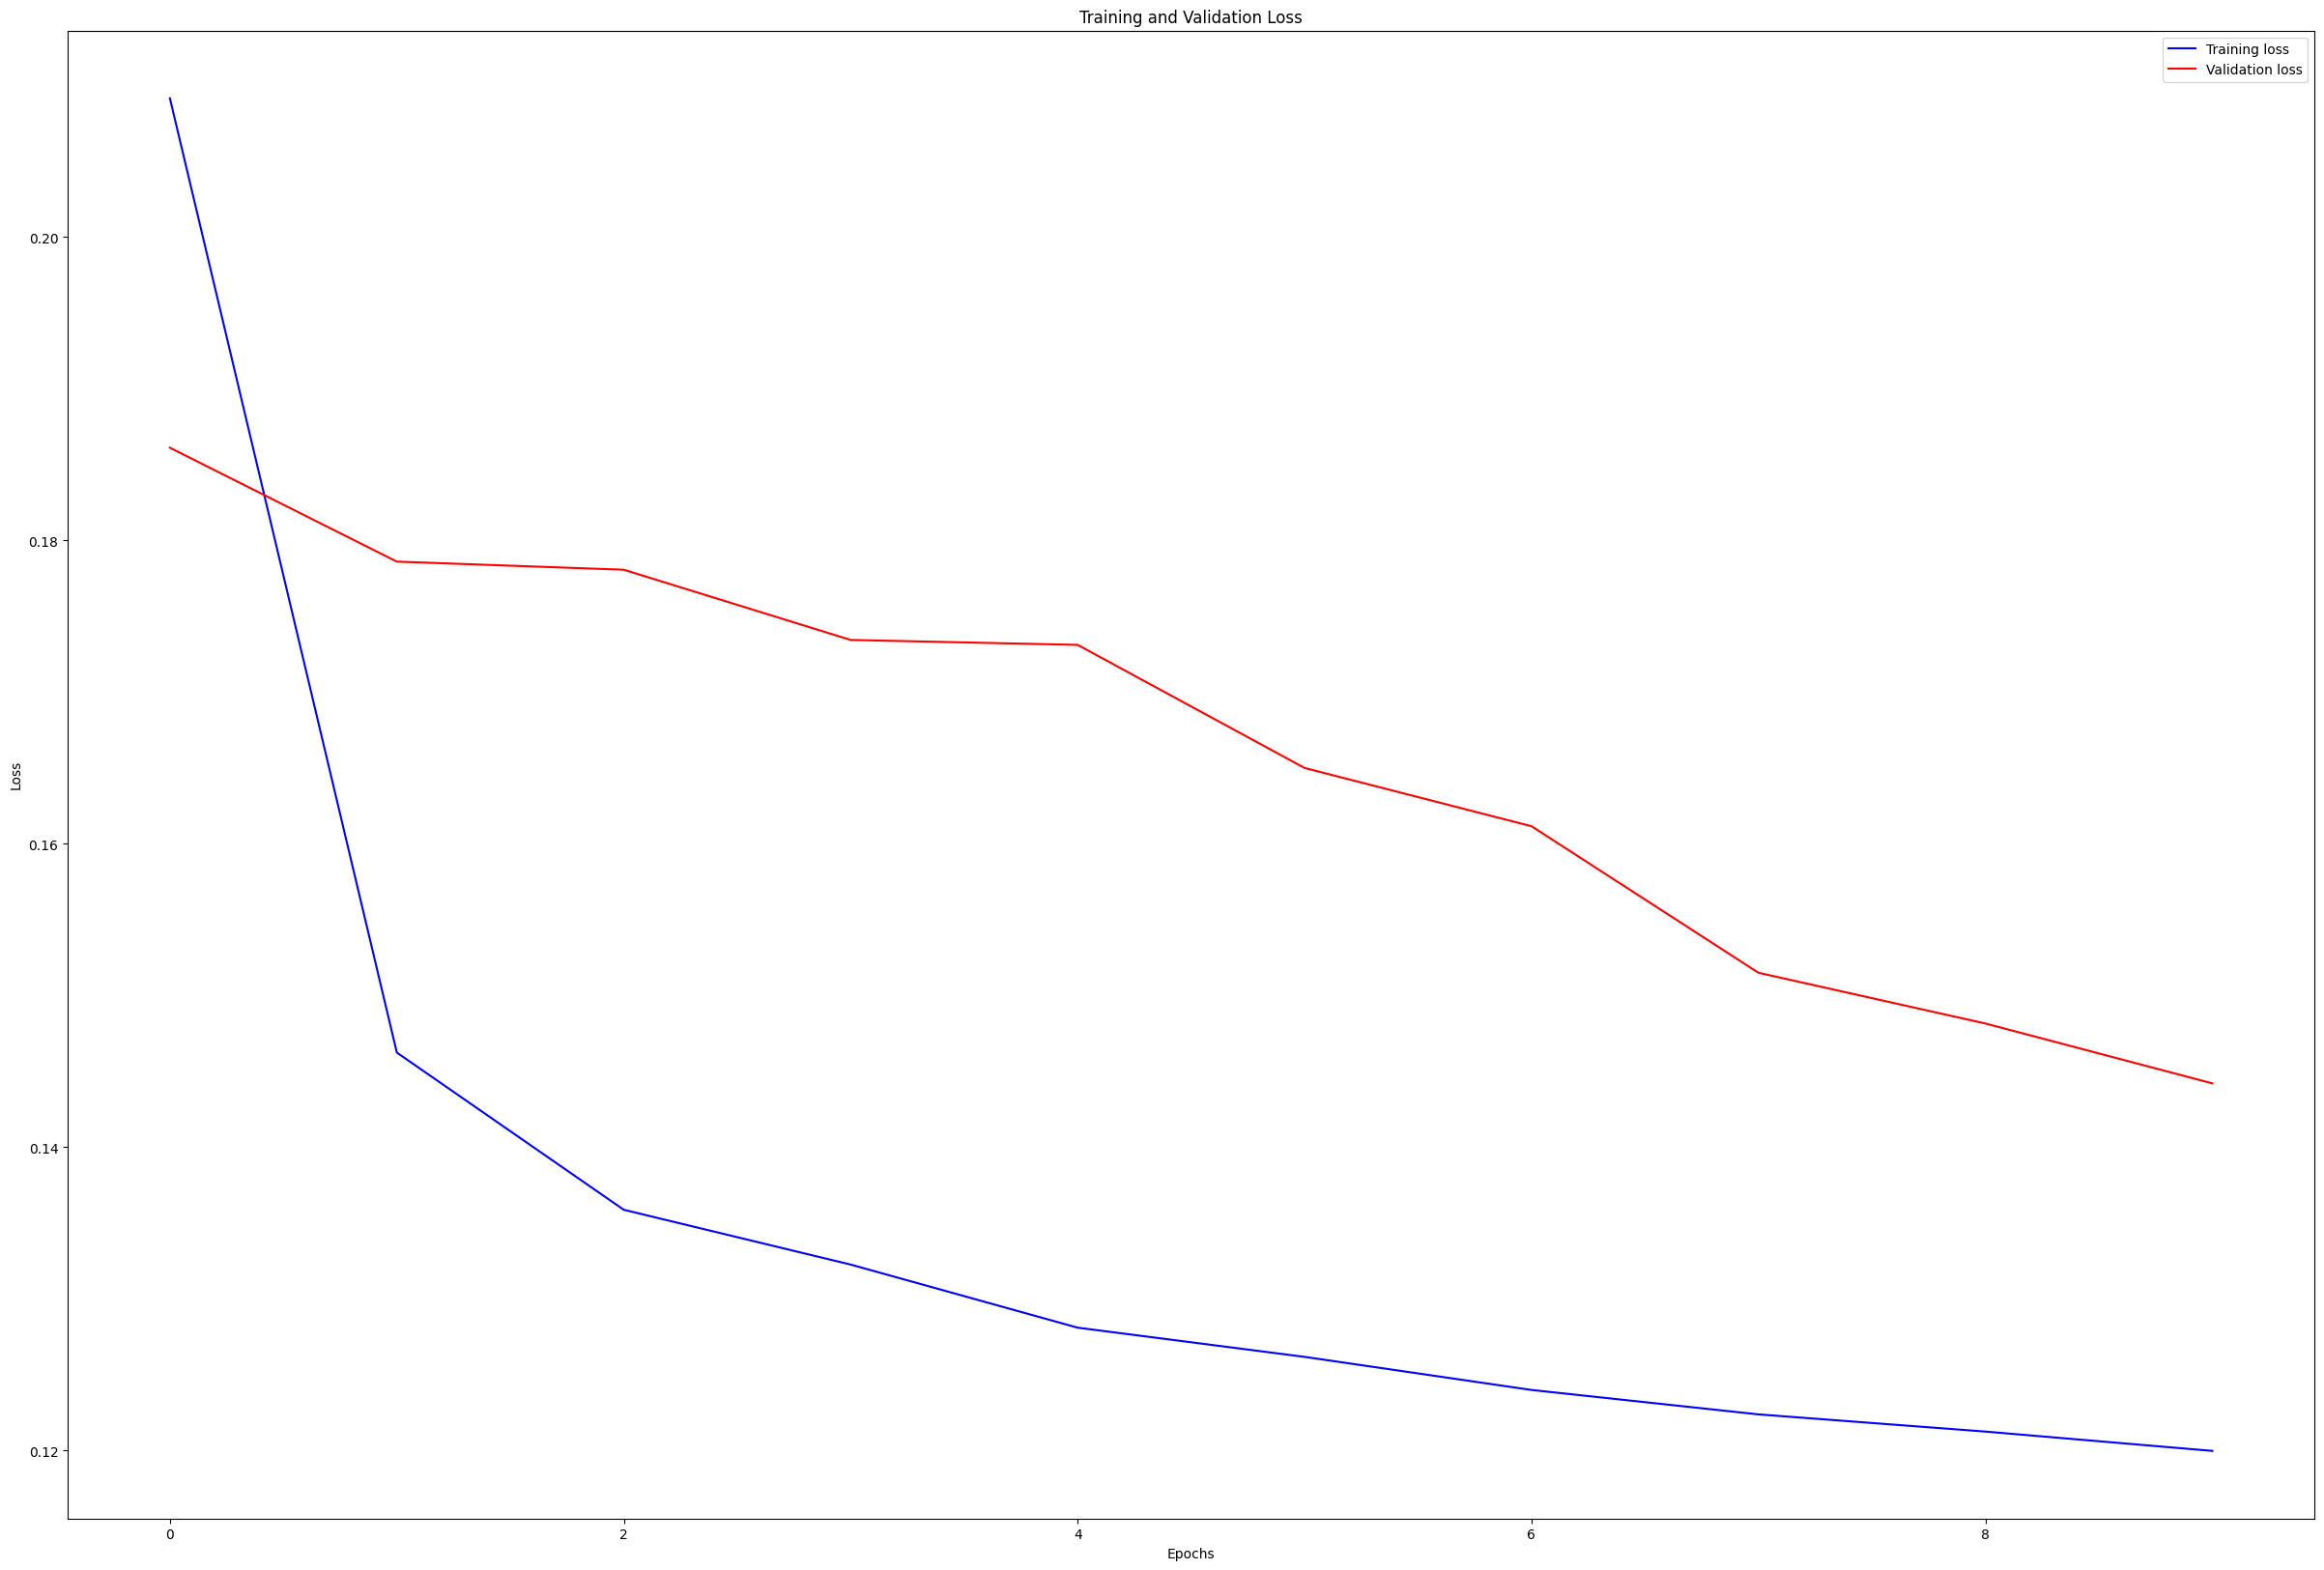

Final val loss:  [0.18611589074134827, 0.17860649526119232, 0.17807181179523468, 0.17344267666339874, 0.17311783134937286, 0.16500318050384521, 0.16116273403167725, 0.1515018343925476, 0.14815674722194672, 0.14421014487743378]
Epoch 1/10
1312/1312 [==============================] - 16s 11ms/step - loss: 0.2512 - val_loss: 0.1851
Epoch 2/10
1312/1312 [==============================] - 14s 11ms/step - loss: 0.1710 - val_loss: 0.1684
Epoch 3/10
1312/1312 [==============================] - 14s 11ms/step - loss: 0.1559 - val_loss: 0.1642
Epoch 4/10
1312/1312 [==============================] - 14s 11ms/step - loss: 0.1485 - val_loss: 0.1572
Epoch 5/10
1312/1312 [==============================] - 15s 11ms/step - loss: 0.1450 - val_loss: 0.1558
Epoch 6/10
1312/1312 [==============================] - 15s 11ms/step - loss: 0.1420 - val_loss: 0.1557
Epoch 7/10
1312/1312 [==============================] - 15s 11ms/step - loss: 0.1403 - val_loss: 0.1521
Epoch 8/10
1312/1312 [=======================

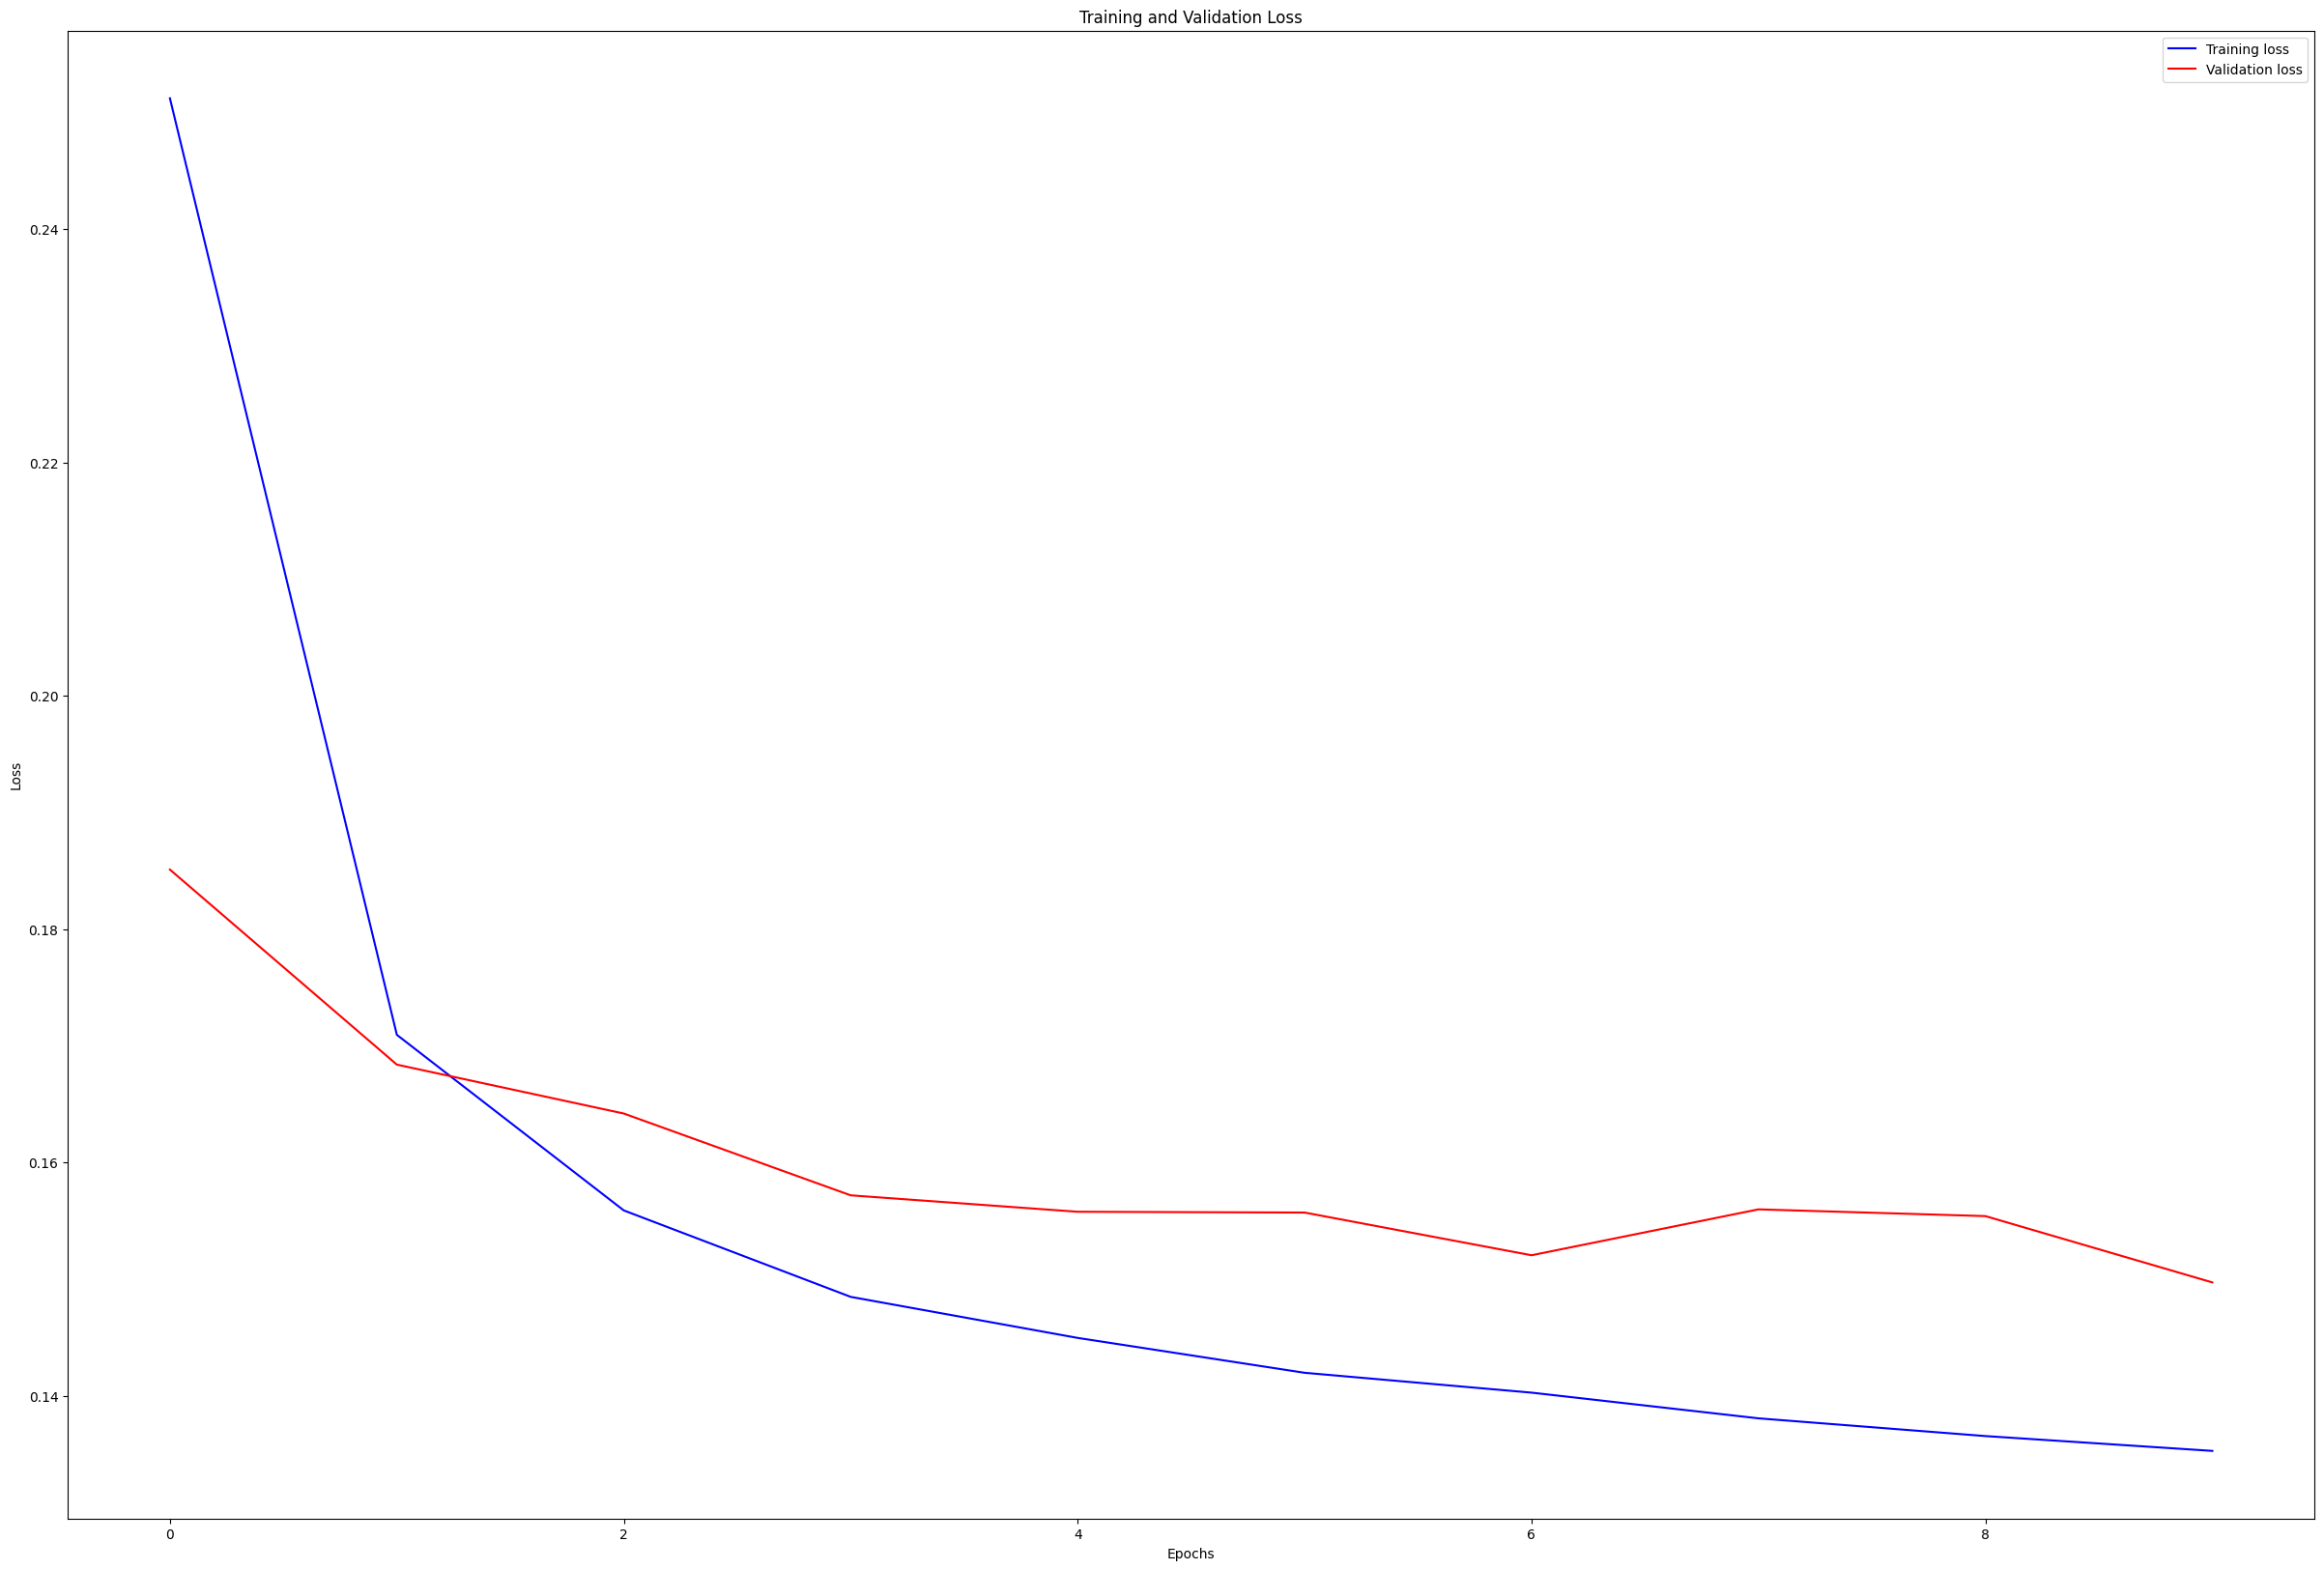

Final val loss:  [0.18511633574962616, 0.16839814186096191, 0.1642056107521057, 0.15719246864318848, 0.15578535199165344, 0.15571728348731995, 0.15205642580986023, 0.15599125623703003, 0.1554124504327774, 0.1497279405593872]
Epoch 1/10
1312/1312 [==============================] - 16s 11ms/step - loss: 0.2748 - val_loss: 0.1892
Epoch 2/10
1312/1312 [==============================] - 15s 12ms/step - loss: 0.1888 - val_loss: 0.1861
Epoch 3/10
1312/1312 [==============================] - 15s 11ms/step - loss: 0.1817 - val_loss: 0.1804
Epoch 4/10
1312/1312 [==============================] - 15s 11ms/step - loss: 0.1759 - val_loss: 0.1726
Epoch 5/10
1312/1312 [==============================] - 14s 11ms/step - loss: 0.1724 - val_loss: 0.1777
Epoch 6/10
1312/1312 [==============================] - 15s 11ms/step - loss: 0.1687 - val_loss: 0.1820
Epoch 7/10
1312/1312 [==============================] - 15s 11ms/step - loss: 0.1658 - val_loss: 0.1753
Epoch 8/10
1312/1312 [=========================

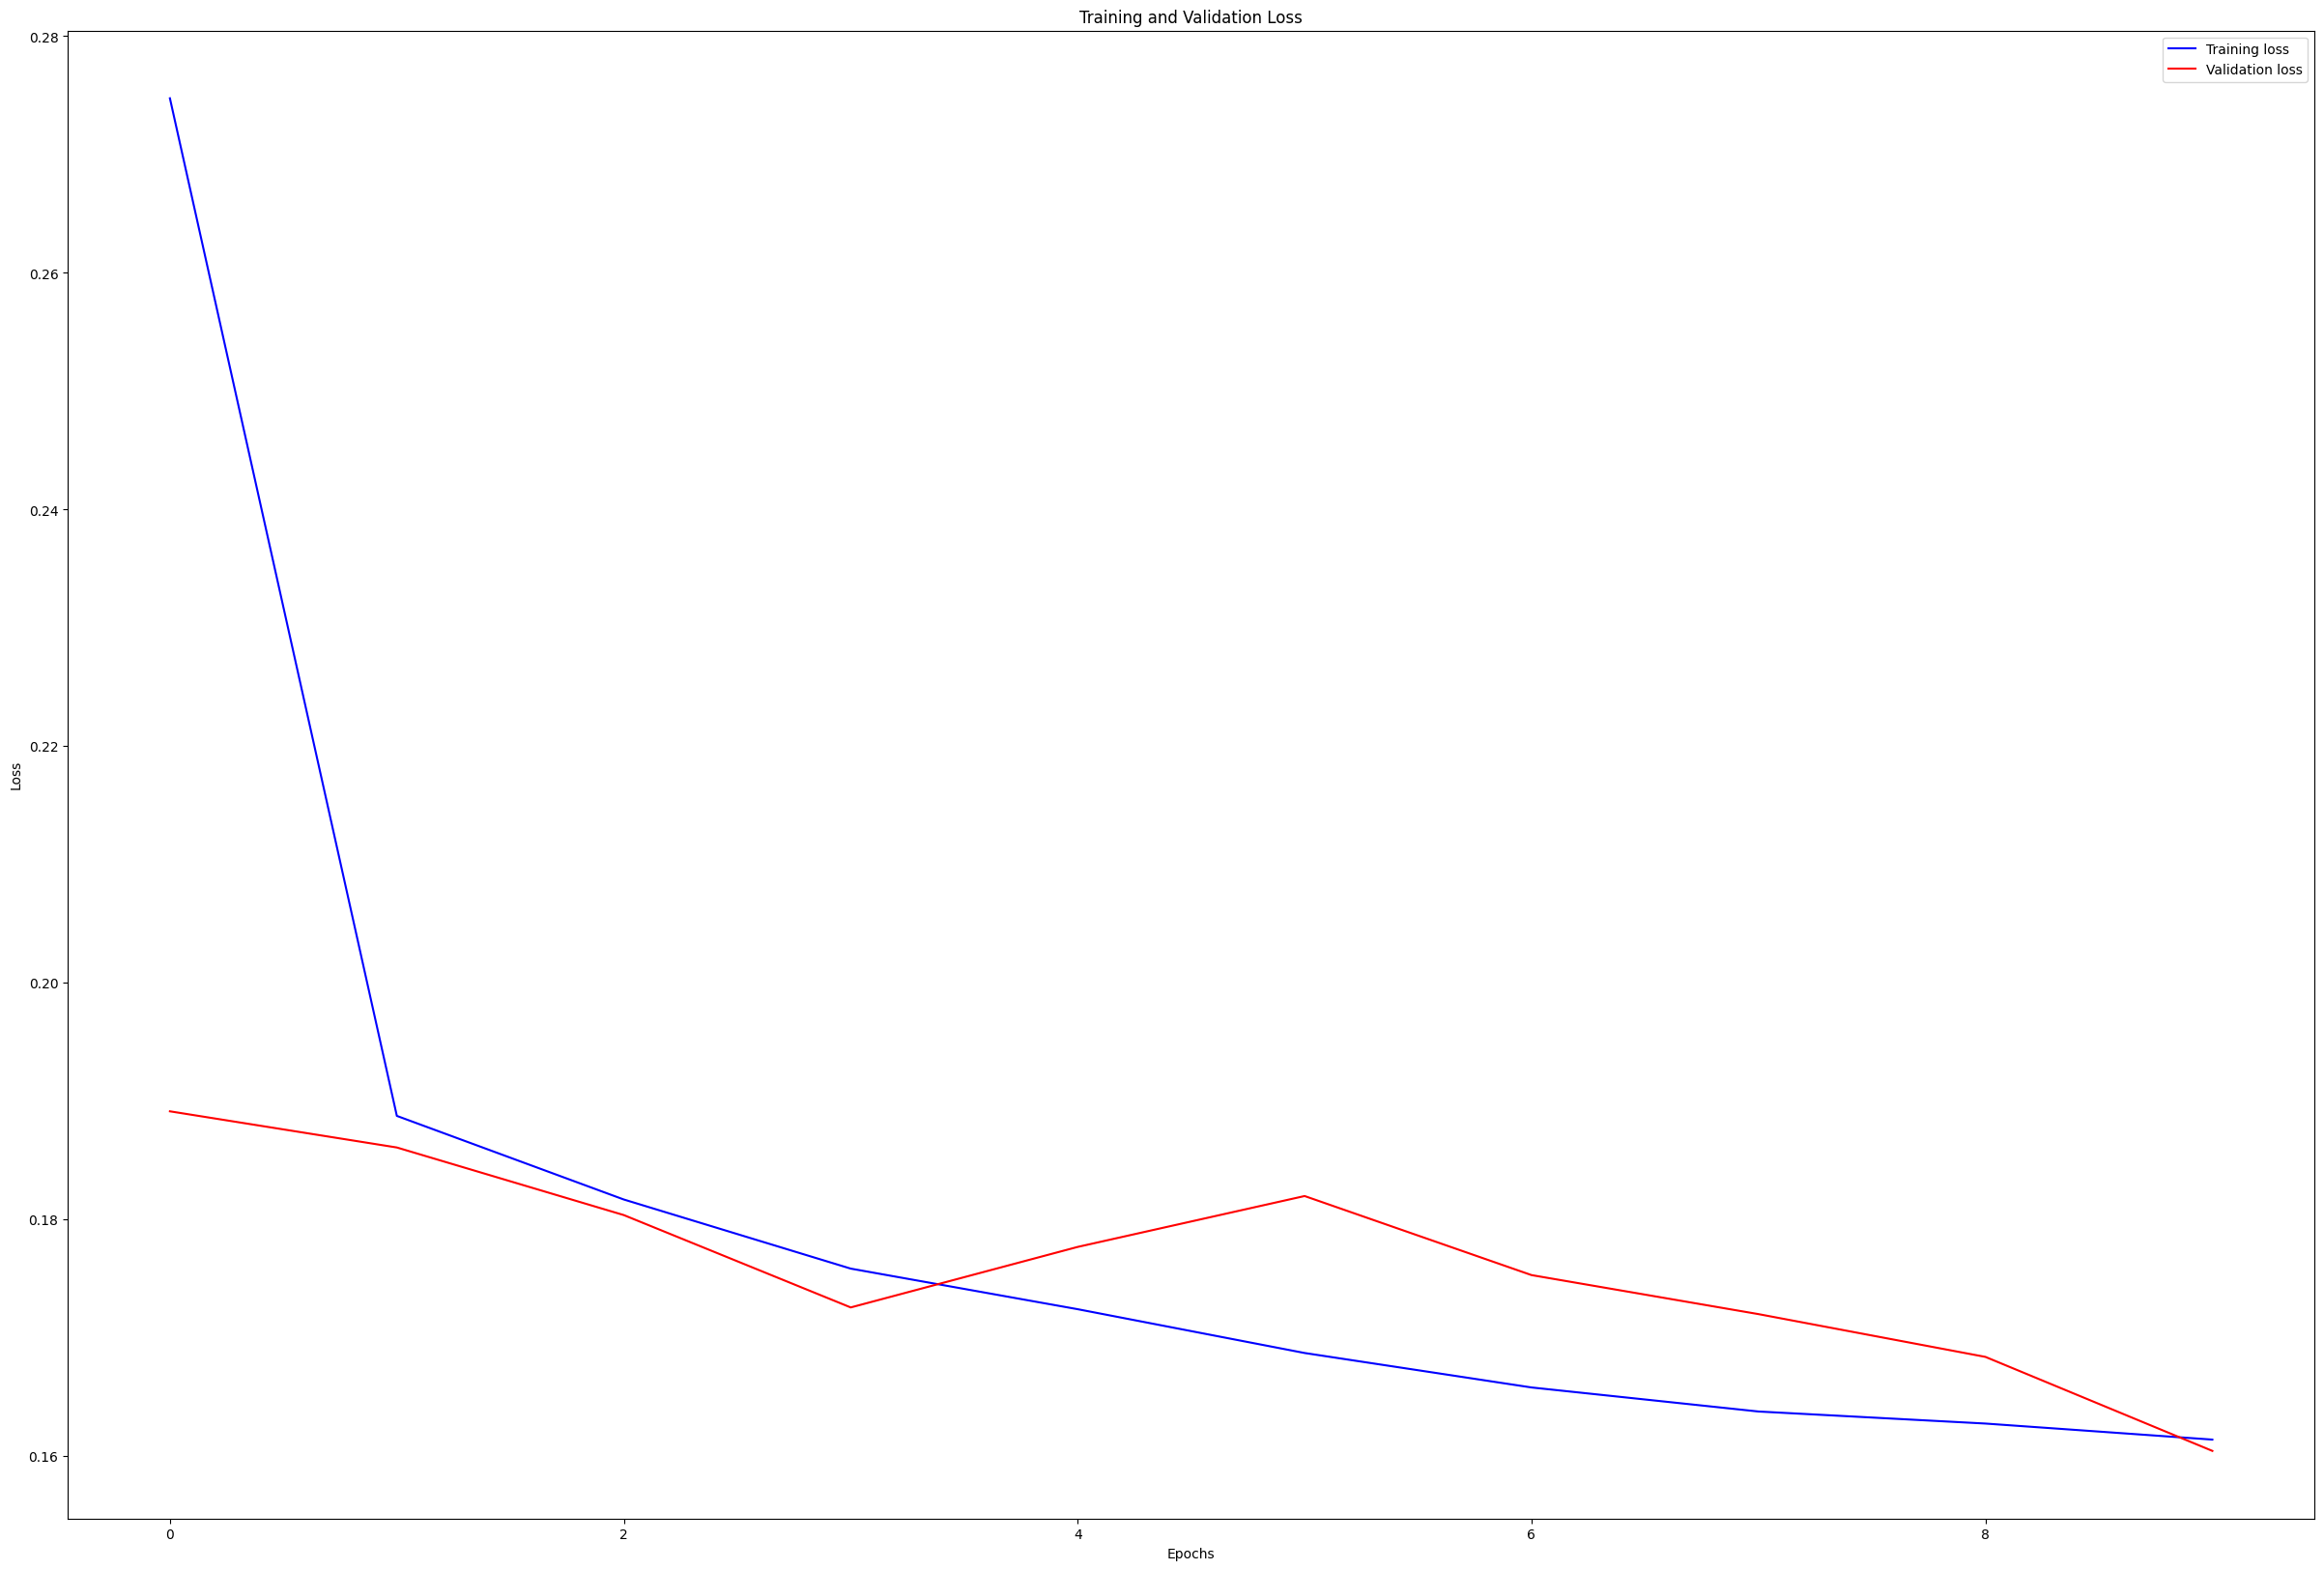

Final val loss:  [0.18915106356143951, 0.1860942542552948, 0.18038344383239746, 0.17257899045944214, 0.1776922345161438, 0.18199273943901062, 0.1753116250038147, 0.172014519572258, 0.16840004920959473, 0.16045689582824707]
Epoch 1/10
1312/1312 [==============================] - 16s 11ms/step - loss: 0.1814 - val_loss: 0.1992
Epoch 2/10
1312/1312 [==============================] - 15s 11ms/step - loss: 0.1379 - val_loss: 0.1931
Epoch 3/10
1312/1312 [==============================] - 15s 11ms/step - loss: 0.1303 - val_loss: 0.1822
Epoch 4/10
1312/1312 [==============================] - 15s 11ms/step - loss: 0.1251 - val_loss: 0.1722
Epoch 5/10
1312/1312 [==============================] - 15s 11ms/step - loss: 0.1225 - val_loss: 0.1557
Epoch 6/10
1312/1312 [==============================] - 15s 11ms/step - loss: 0.1199 - val_loss: 0.1497
Epoch 7/10
1312/1312 [==============================] - 15s 11ms/step - loss: 0.1174 - val_loss: 0.1507
Epoch 8/10
1312/1312 [===========================

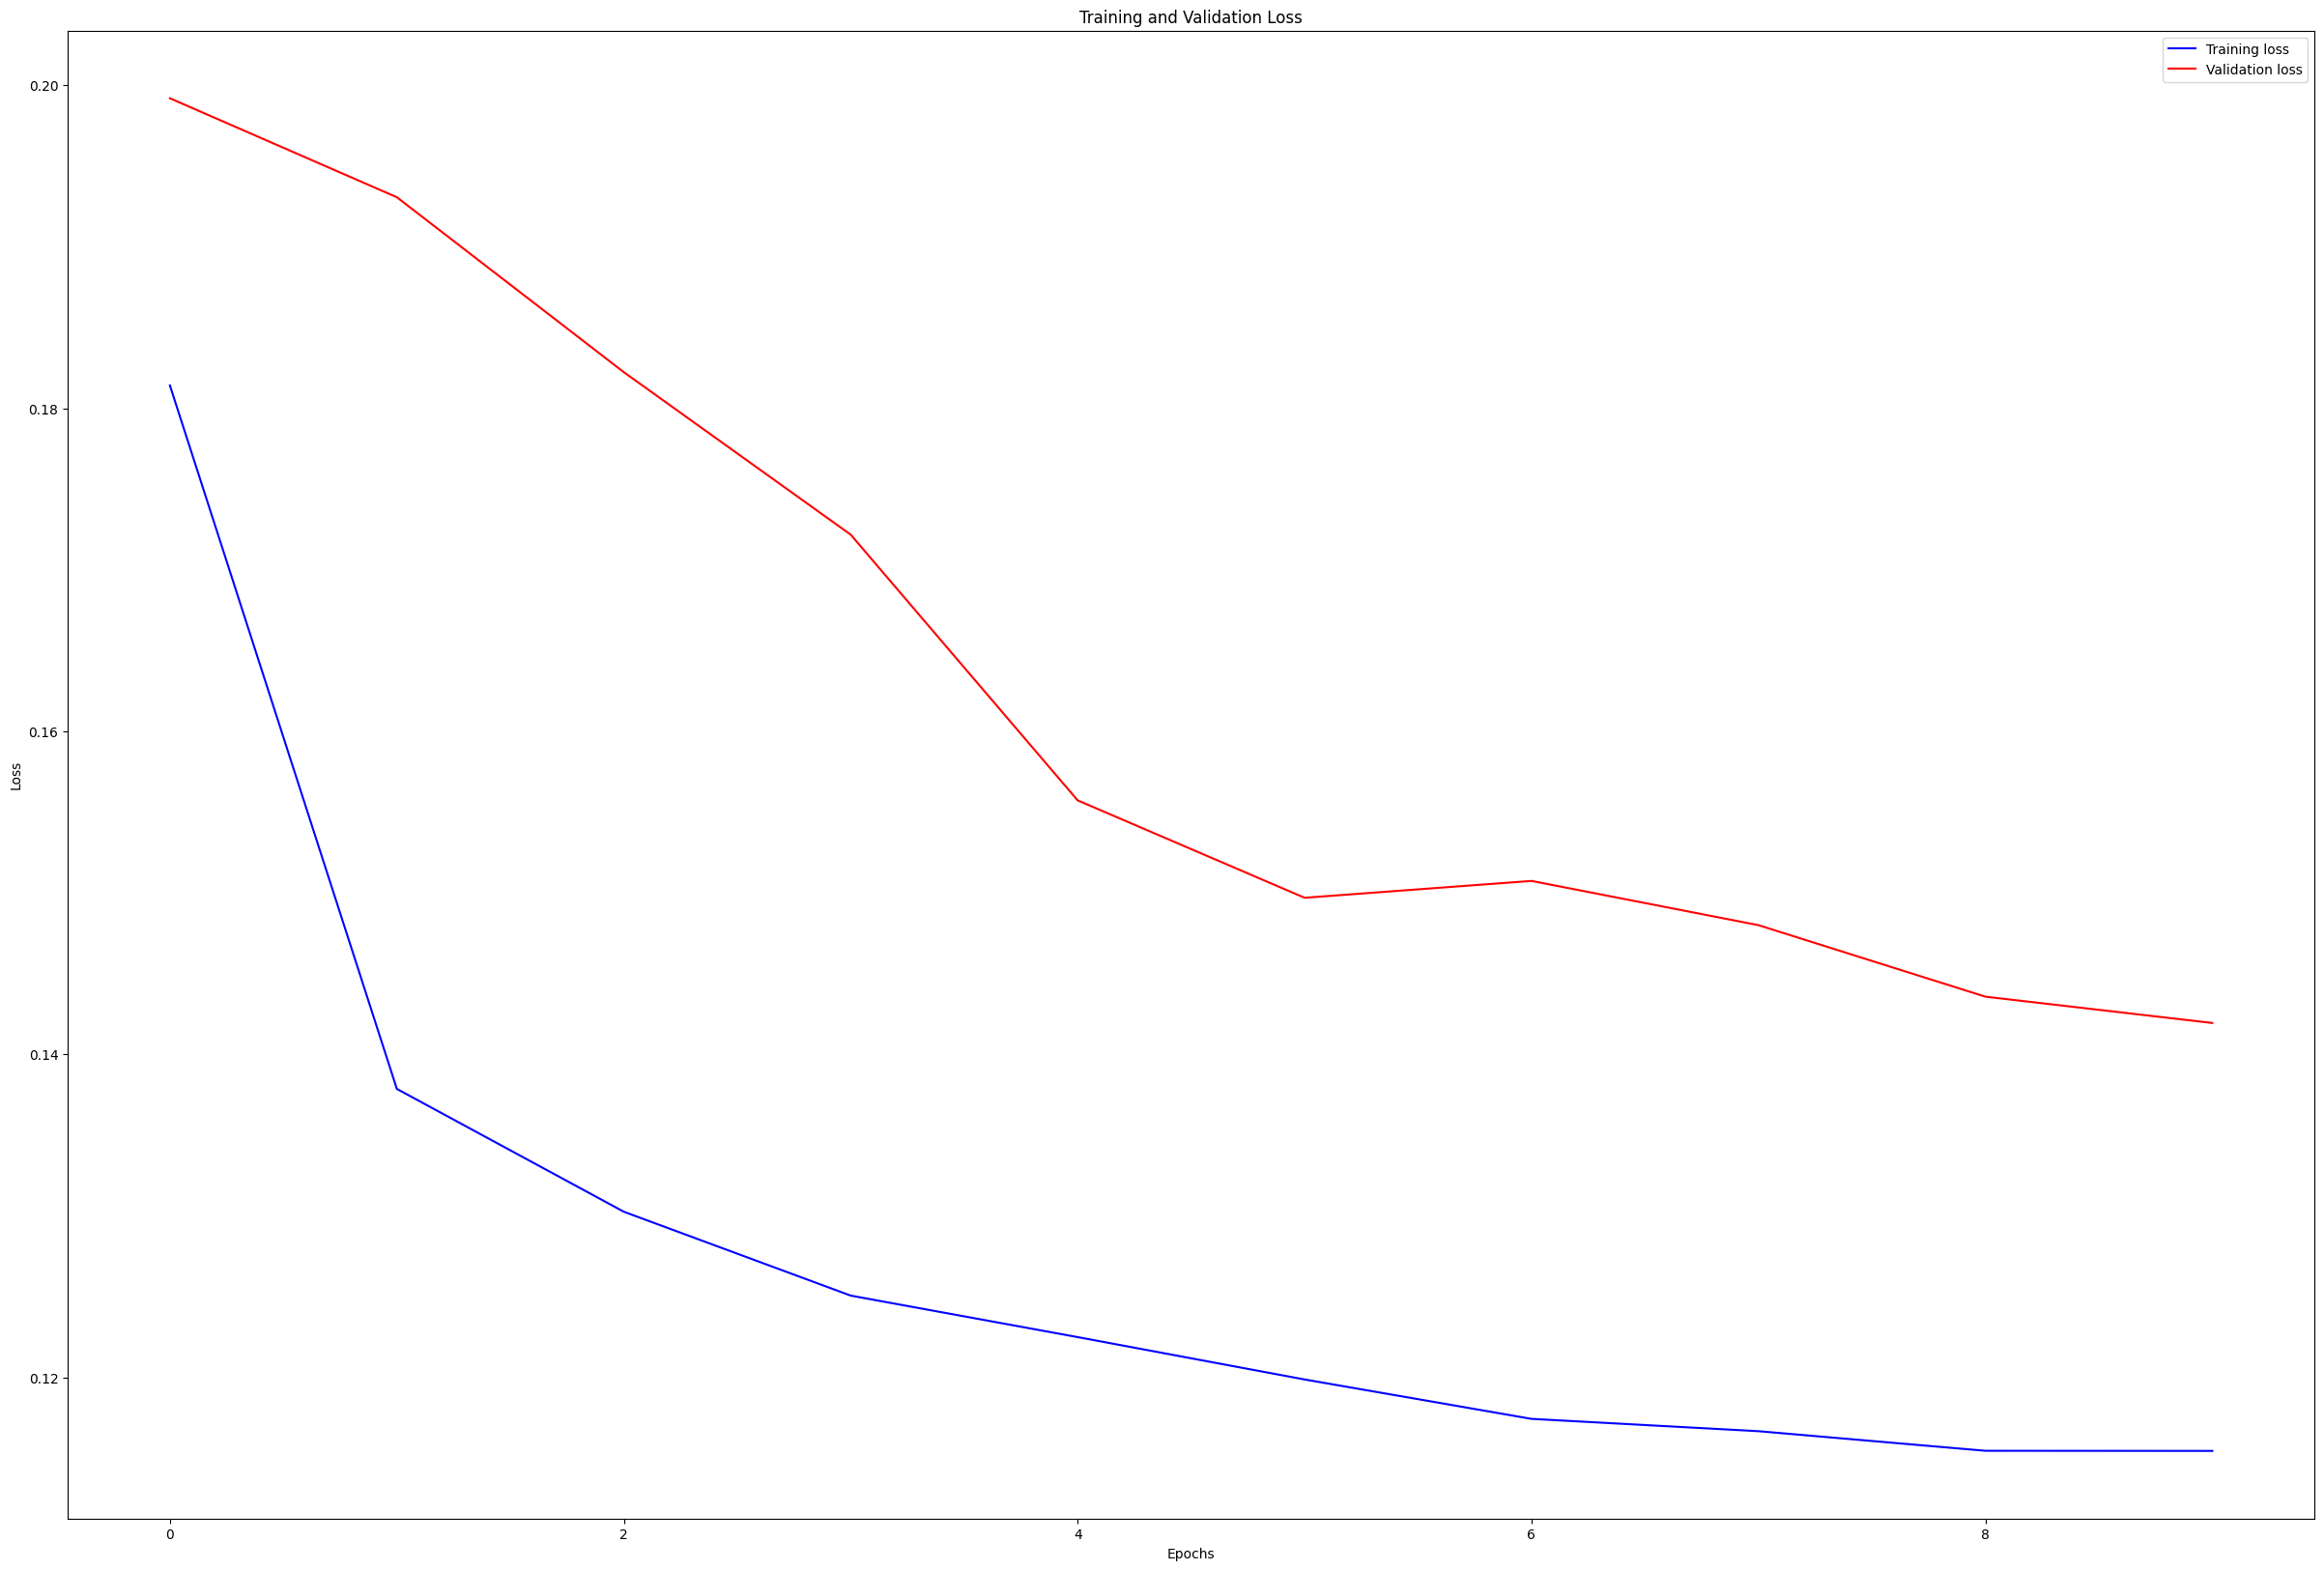

Final val loss:  [0.19919566810131073, 0.1930694431066513, 0.1822391152381897, 0.17217648029327393, 0.15572521090507507, 0.14969514310359955, 0.15073810517787933, 0.14799931645393372, 0.14357130229473114, 0.14194351434707642]
Epoch 1/10
1312/1312 [==============================] - 16s 11ms/step - loss: 0.1981 - val_loss: 0.1851
Epoch 2/10
1312/1312 [==============================] - 14s 11ms/step - loss: 0.1503 - val_loss: 0.2091
Epoch 3/10
1312/1312 [==============================] - 15s 11ms/step - loss: 0.1449 - val_loss: 0.1980
Epoch 4/10
1312/1312 [==============================] - 15s 11ms/step - loss: 0.1358 - val_loss: 0.1830
Epoch 5/10
1312/1312 [==============================] - 15s 11ms/step - loss: 0.1324 - val_loss: 0.1707
Epoch 6/10
1312/1312 [==============================] - 15s 11ms/step - loss: 0.1286 - val_loss: 0.1663
Epoch 7/10
1312/1312 [==============================] - 15s 11ms/step - loss: 0.1276 - val_loss: 0.1581
Epoch 8/10
1312/1312 [========================

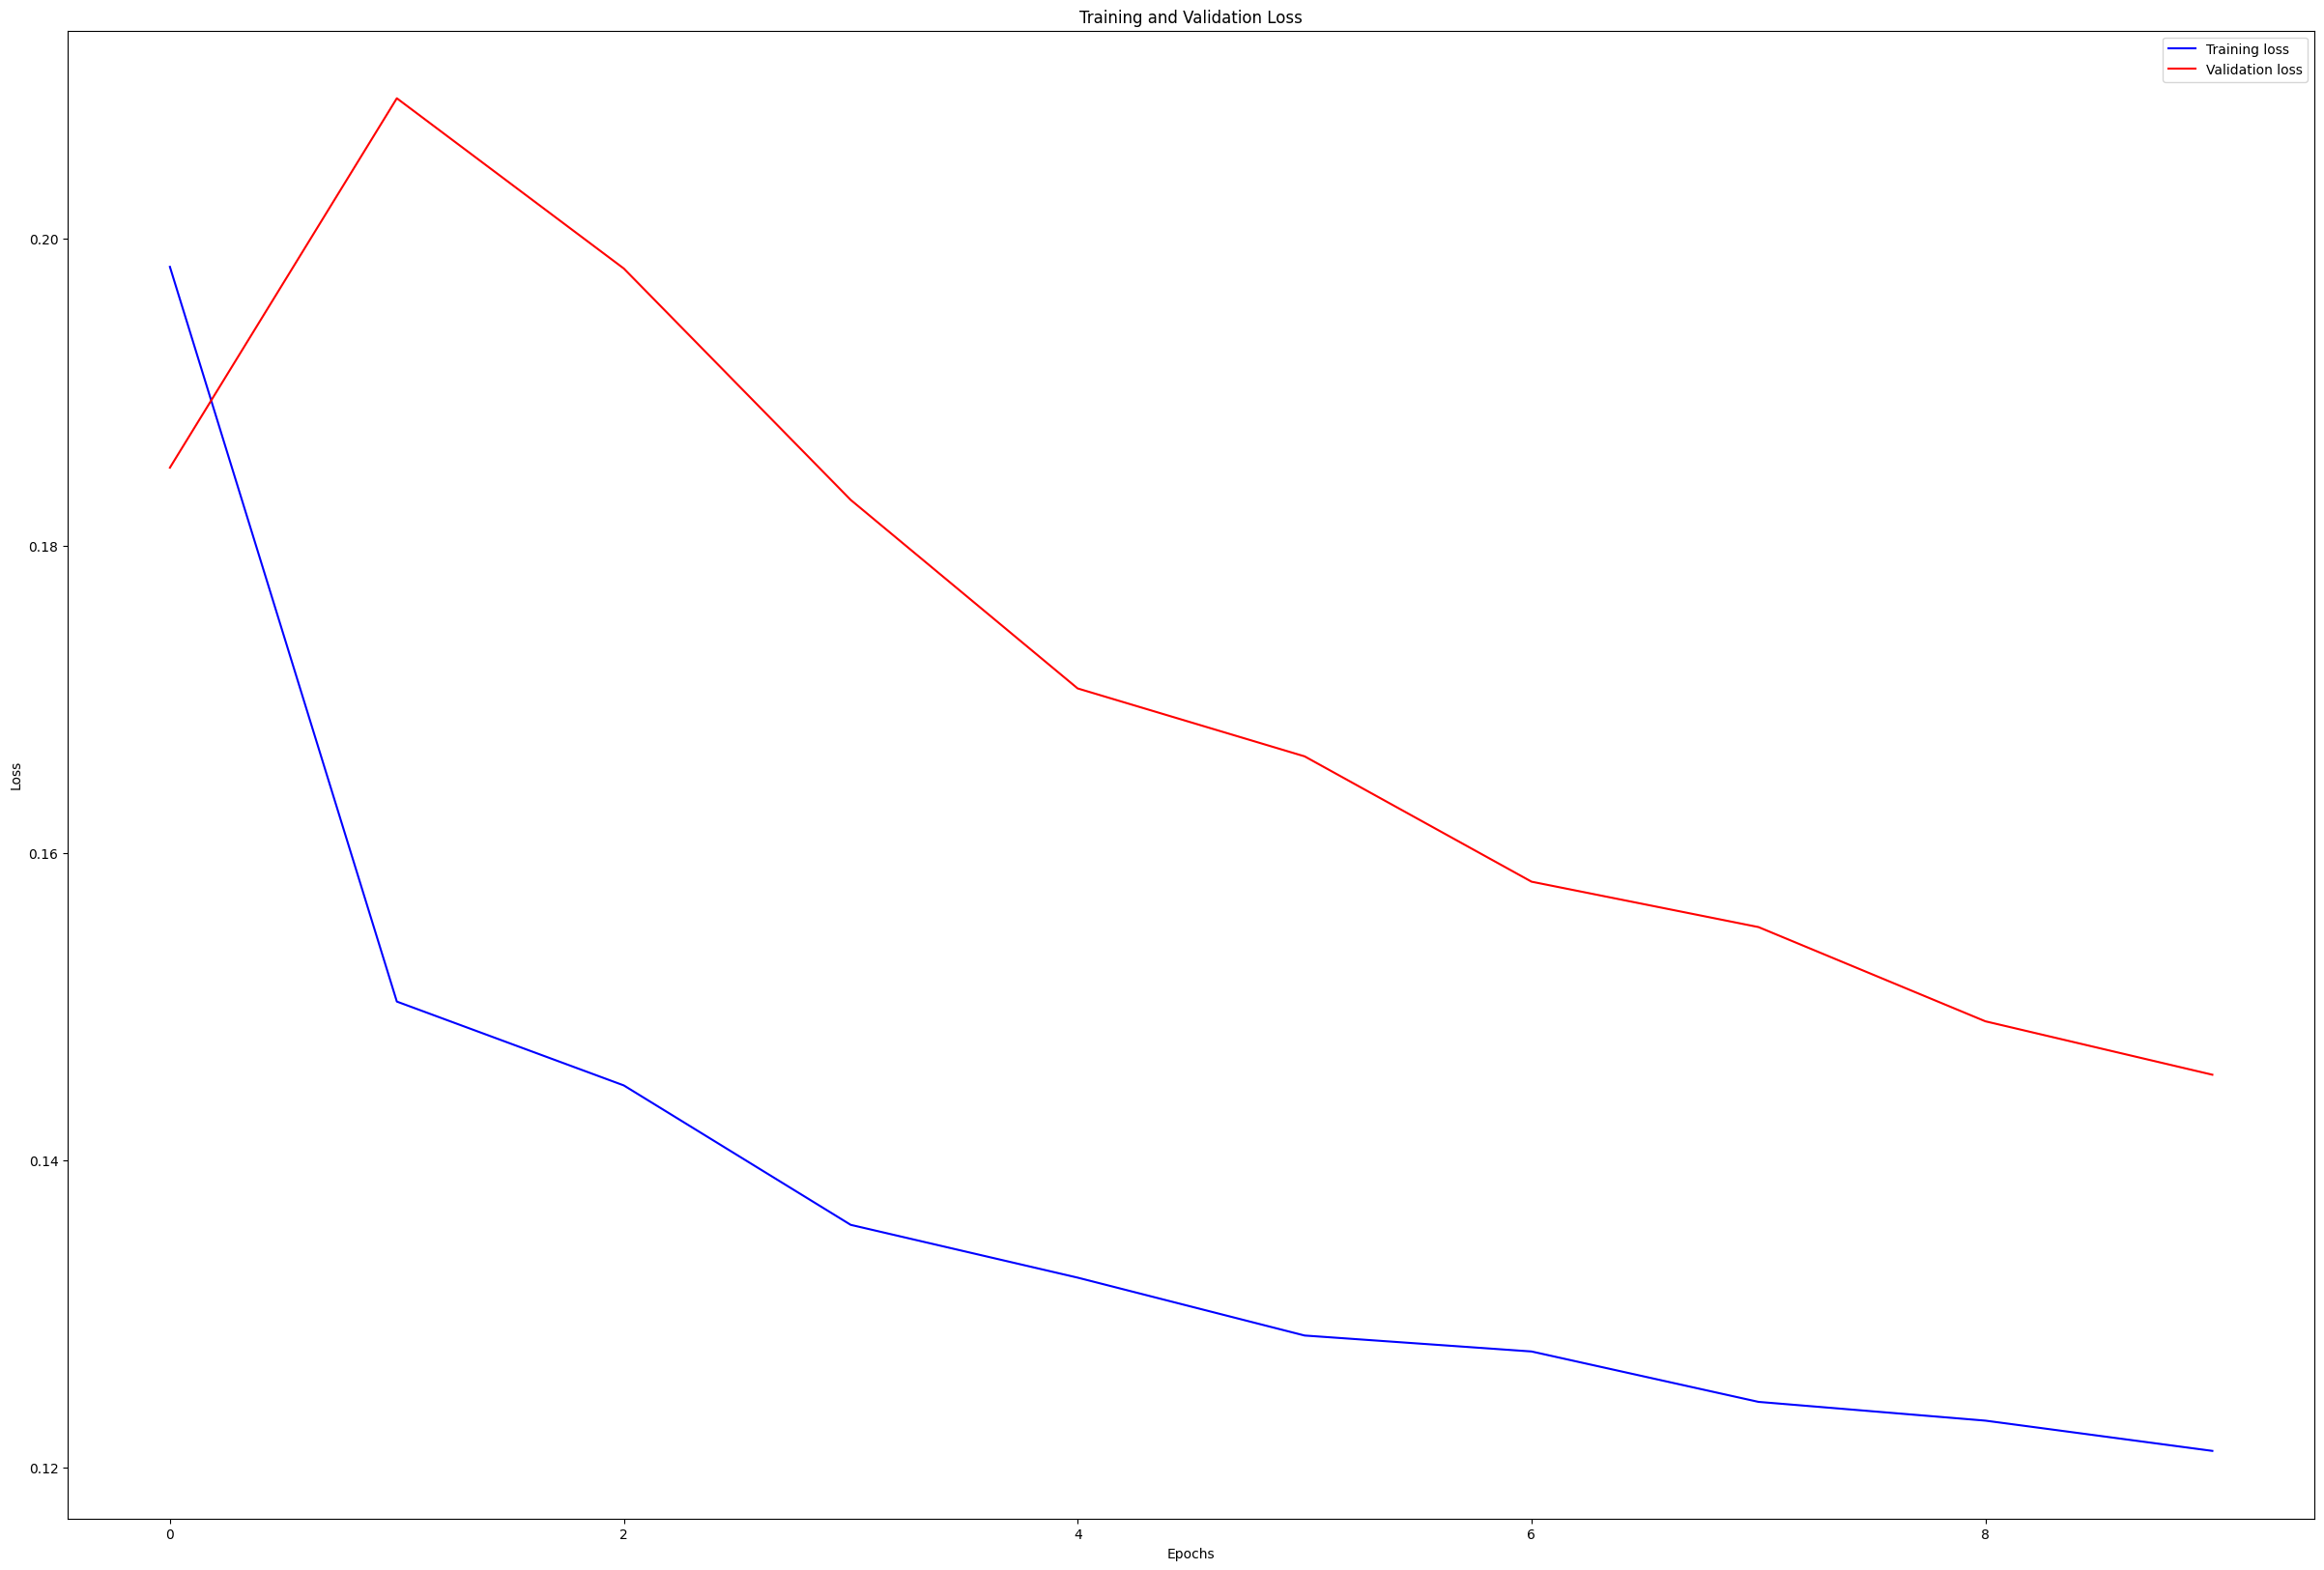

Final val loss:  [0.18507815897464752, 0.20912078022956848, 0.19804203510284424, 0.1829782873392105, 0.17070795595645905, 0.1662873774766922, 0.15812957286834717, 0.15517520904541016, 0.14904122054576874, 0.14556483924388885]
Epoch 1/10
1312/1312 [==============================] - 17s 12ms/step - loss: 0.2152 - val_loss: 0.2162
Epoch 2/10
1312/1312 [==============================] - 15s 11ms/step - loss: 0.1665 - val_loss: 0.2041
Epoch 3/10
1312/1312 [==============================] - 15s 11ms/step - loss: 0.1559 - val_loss: 0.1981
Epoch 4/10
1312/1312 [==============================] - 15s 11ms/step - loss: 0.1514 - val_loss: 0.1772
Epoch 5/10
1312/1312 [==============================] - 15s 11ms/step - loss: 0.1465 - val_loss: 0.1775
Epoch 6/10
1312/1312 [==============================] - 15s 11ms/step - loss: 0.1441 - val_loss: 0.1717
Epoch 7/10
1312/1312 [==============================] - 15s 11ms/step - loss: 0.1420 - val_loss: 0.1640
Epoch 8/10
1312/1312 [========================

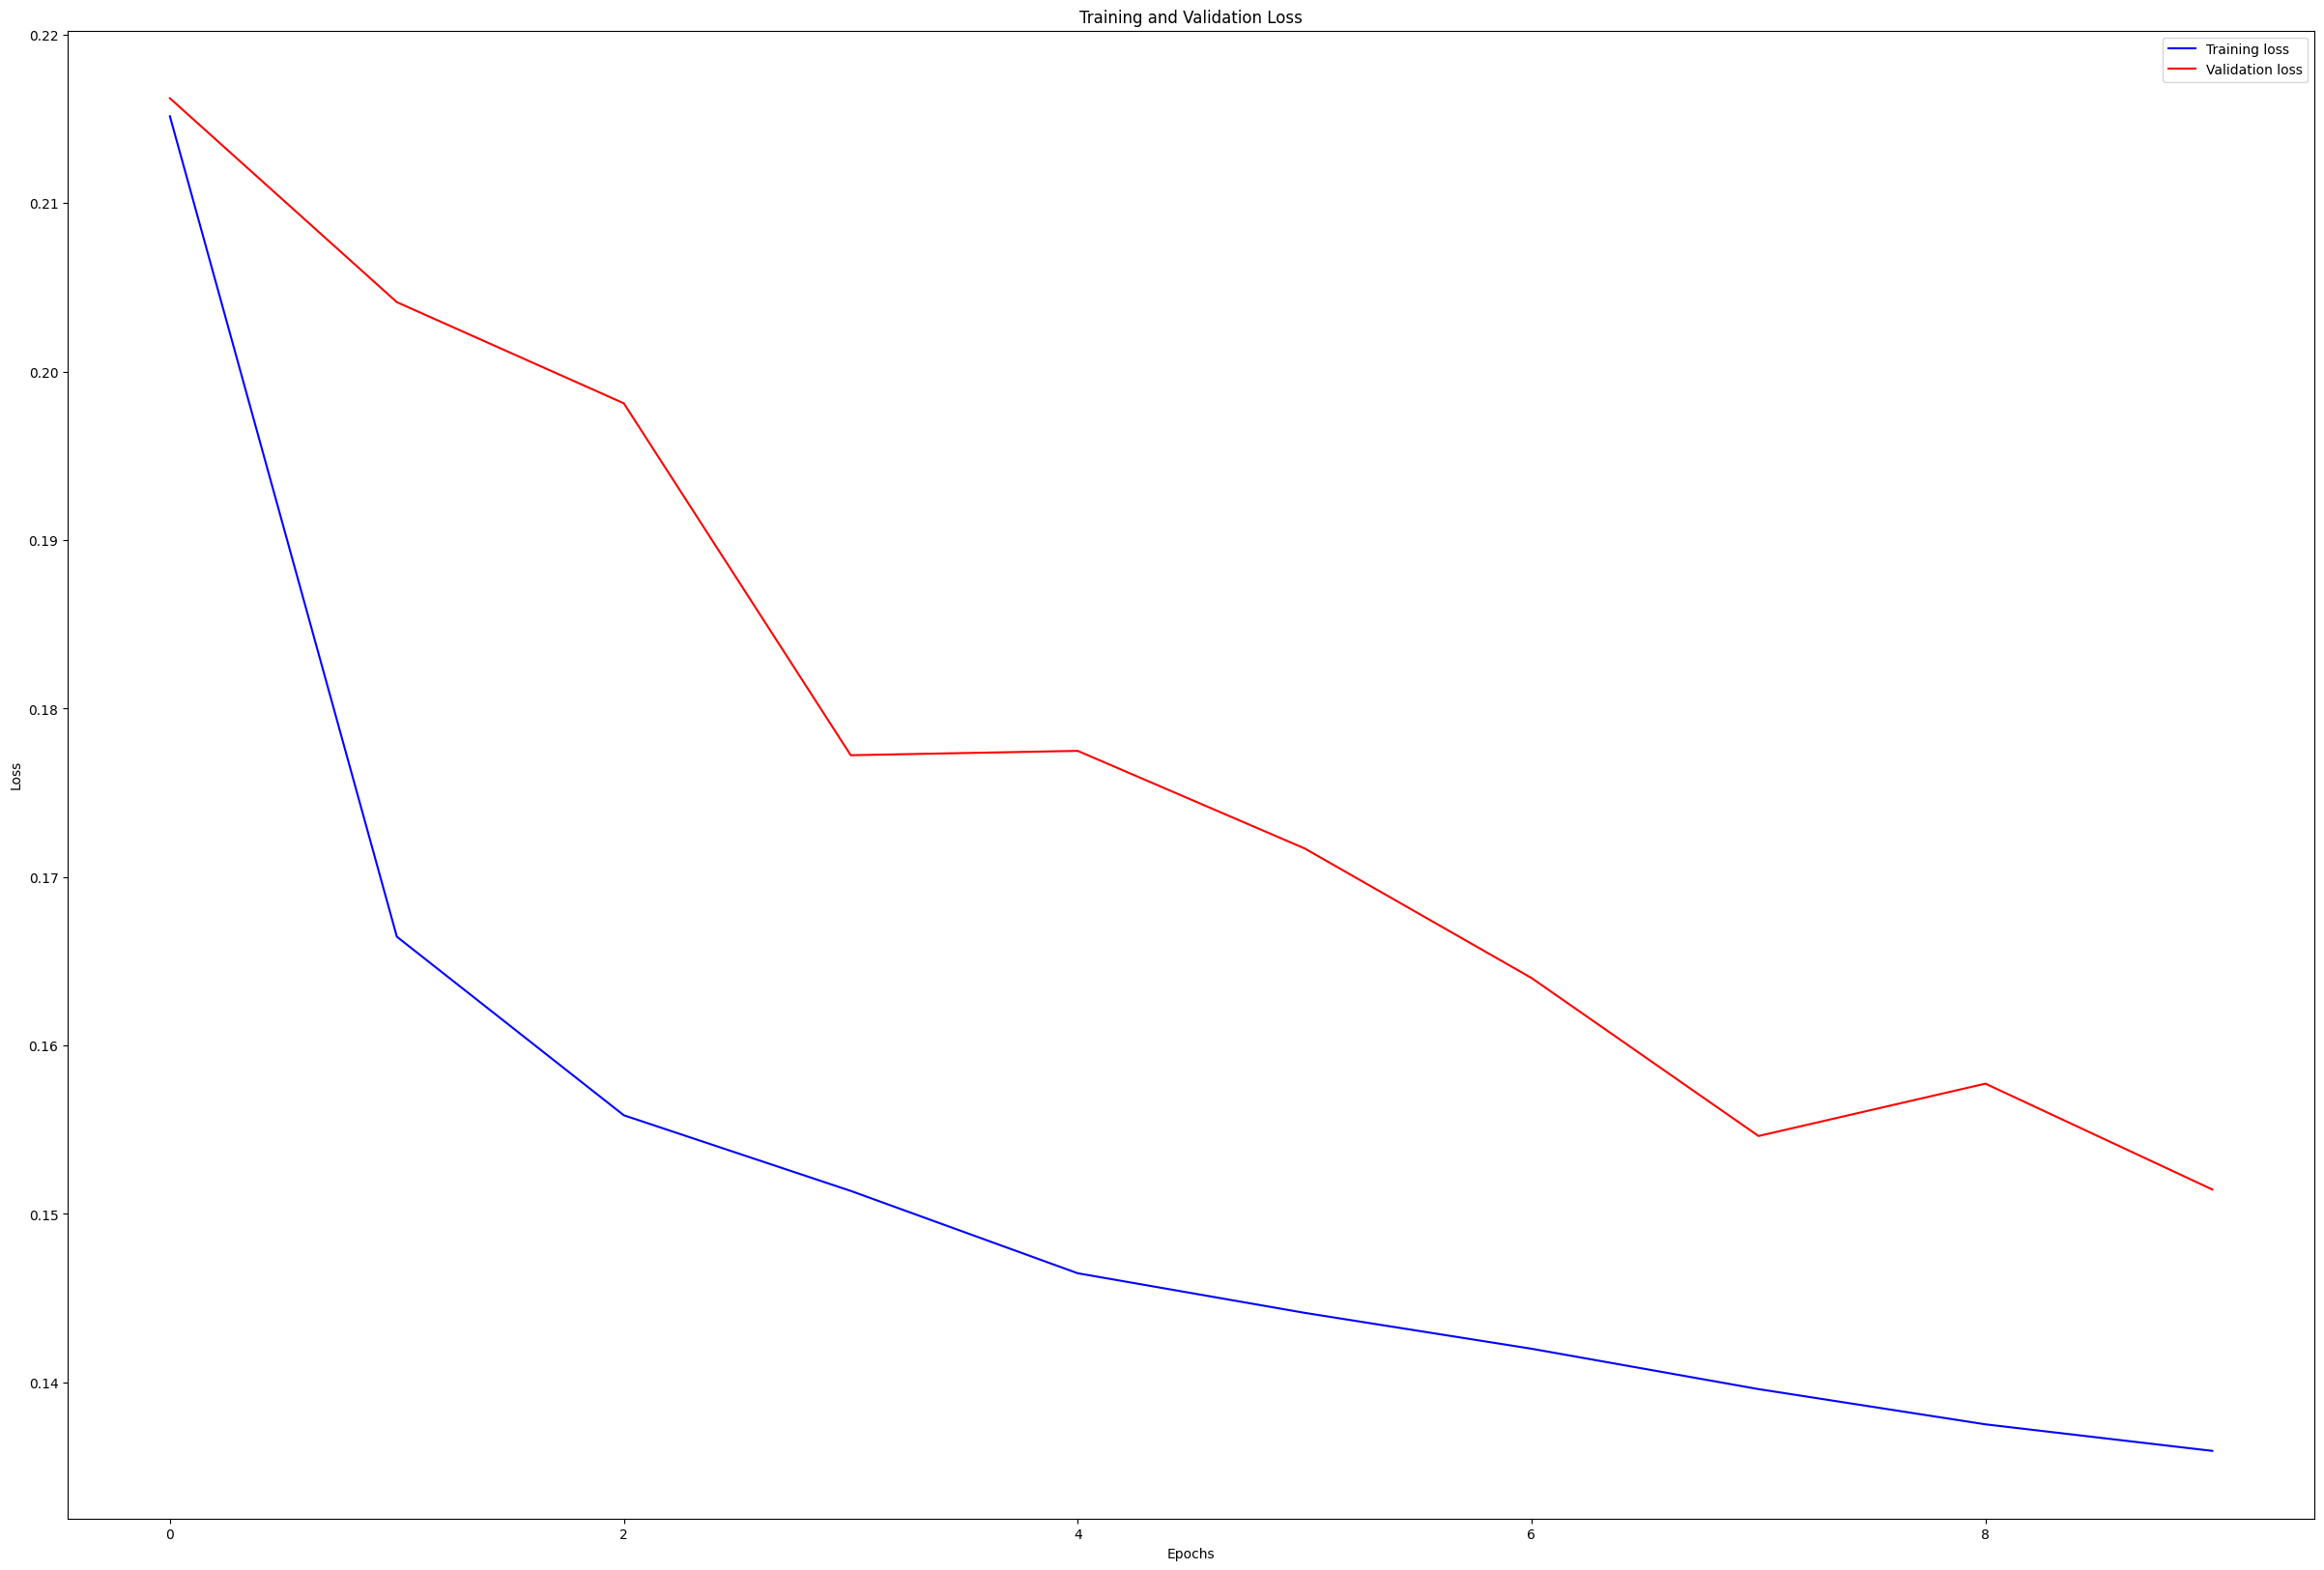

Final val loss:  [0.2162283957004547, 0.20412538945674896, 0.1981228142976761, 0.17723070085048676, 0.17749005556106567, 0.171698197722435, 0.16400544345378876, 0.1546265035867691, 0.15773458778858185, 0.15145045518875122]
Epoch 1/10
1312/1312 [==============================] - 17s 11ms/step - loss: 0.1801 - val_loss: 0.1903
Epoch 2/10
1312/1312 [==============================] - 15s 11ms/step - loss: 0.1421 - val_loss: 0.2247
Epoch 3/10
1312/1312 [==============================] - 15s 11ms/step - loss: 0.1332 - val_loss: 0.2113
Epoch 4/10
1312/1312 [==============================] - 15s 11ms/step - loss: 0.1288 - val_loss: 0.1881
Epoch 5/10
1312/1312 [==============================] - 15s 11ms/step - loss: 0.1230 - val_loss: 0.1821
Epoch 6/10
1312/1312 [==============================] - 15s 11ms/step - loss: 0.1205 - val_loss: 0.1713
Epoch 7/10
1312/1312 [==============================] - 15s 11ms/step - loss: 0.1172 - val_loss: 0.1682
Epoch 8/10
1312/1312 [===========================

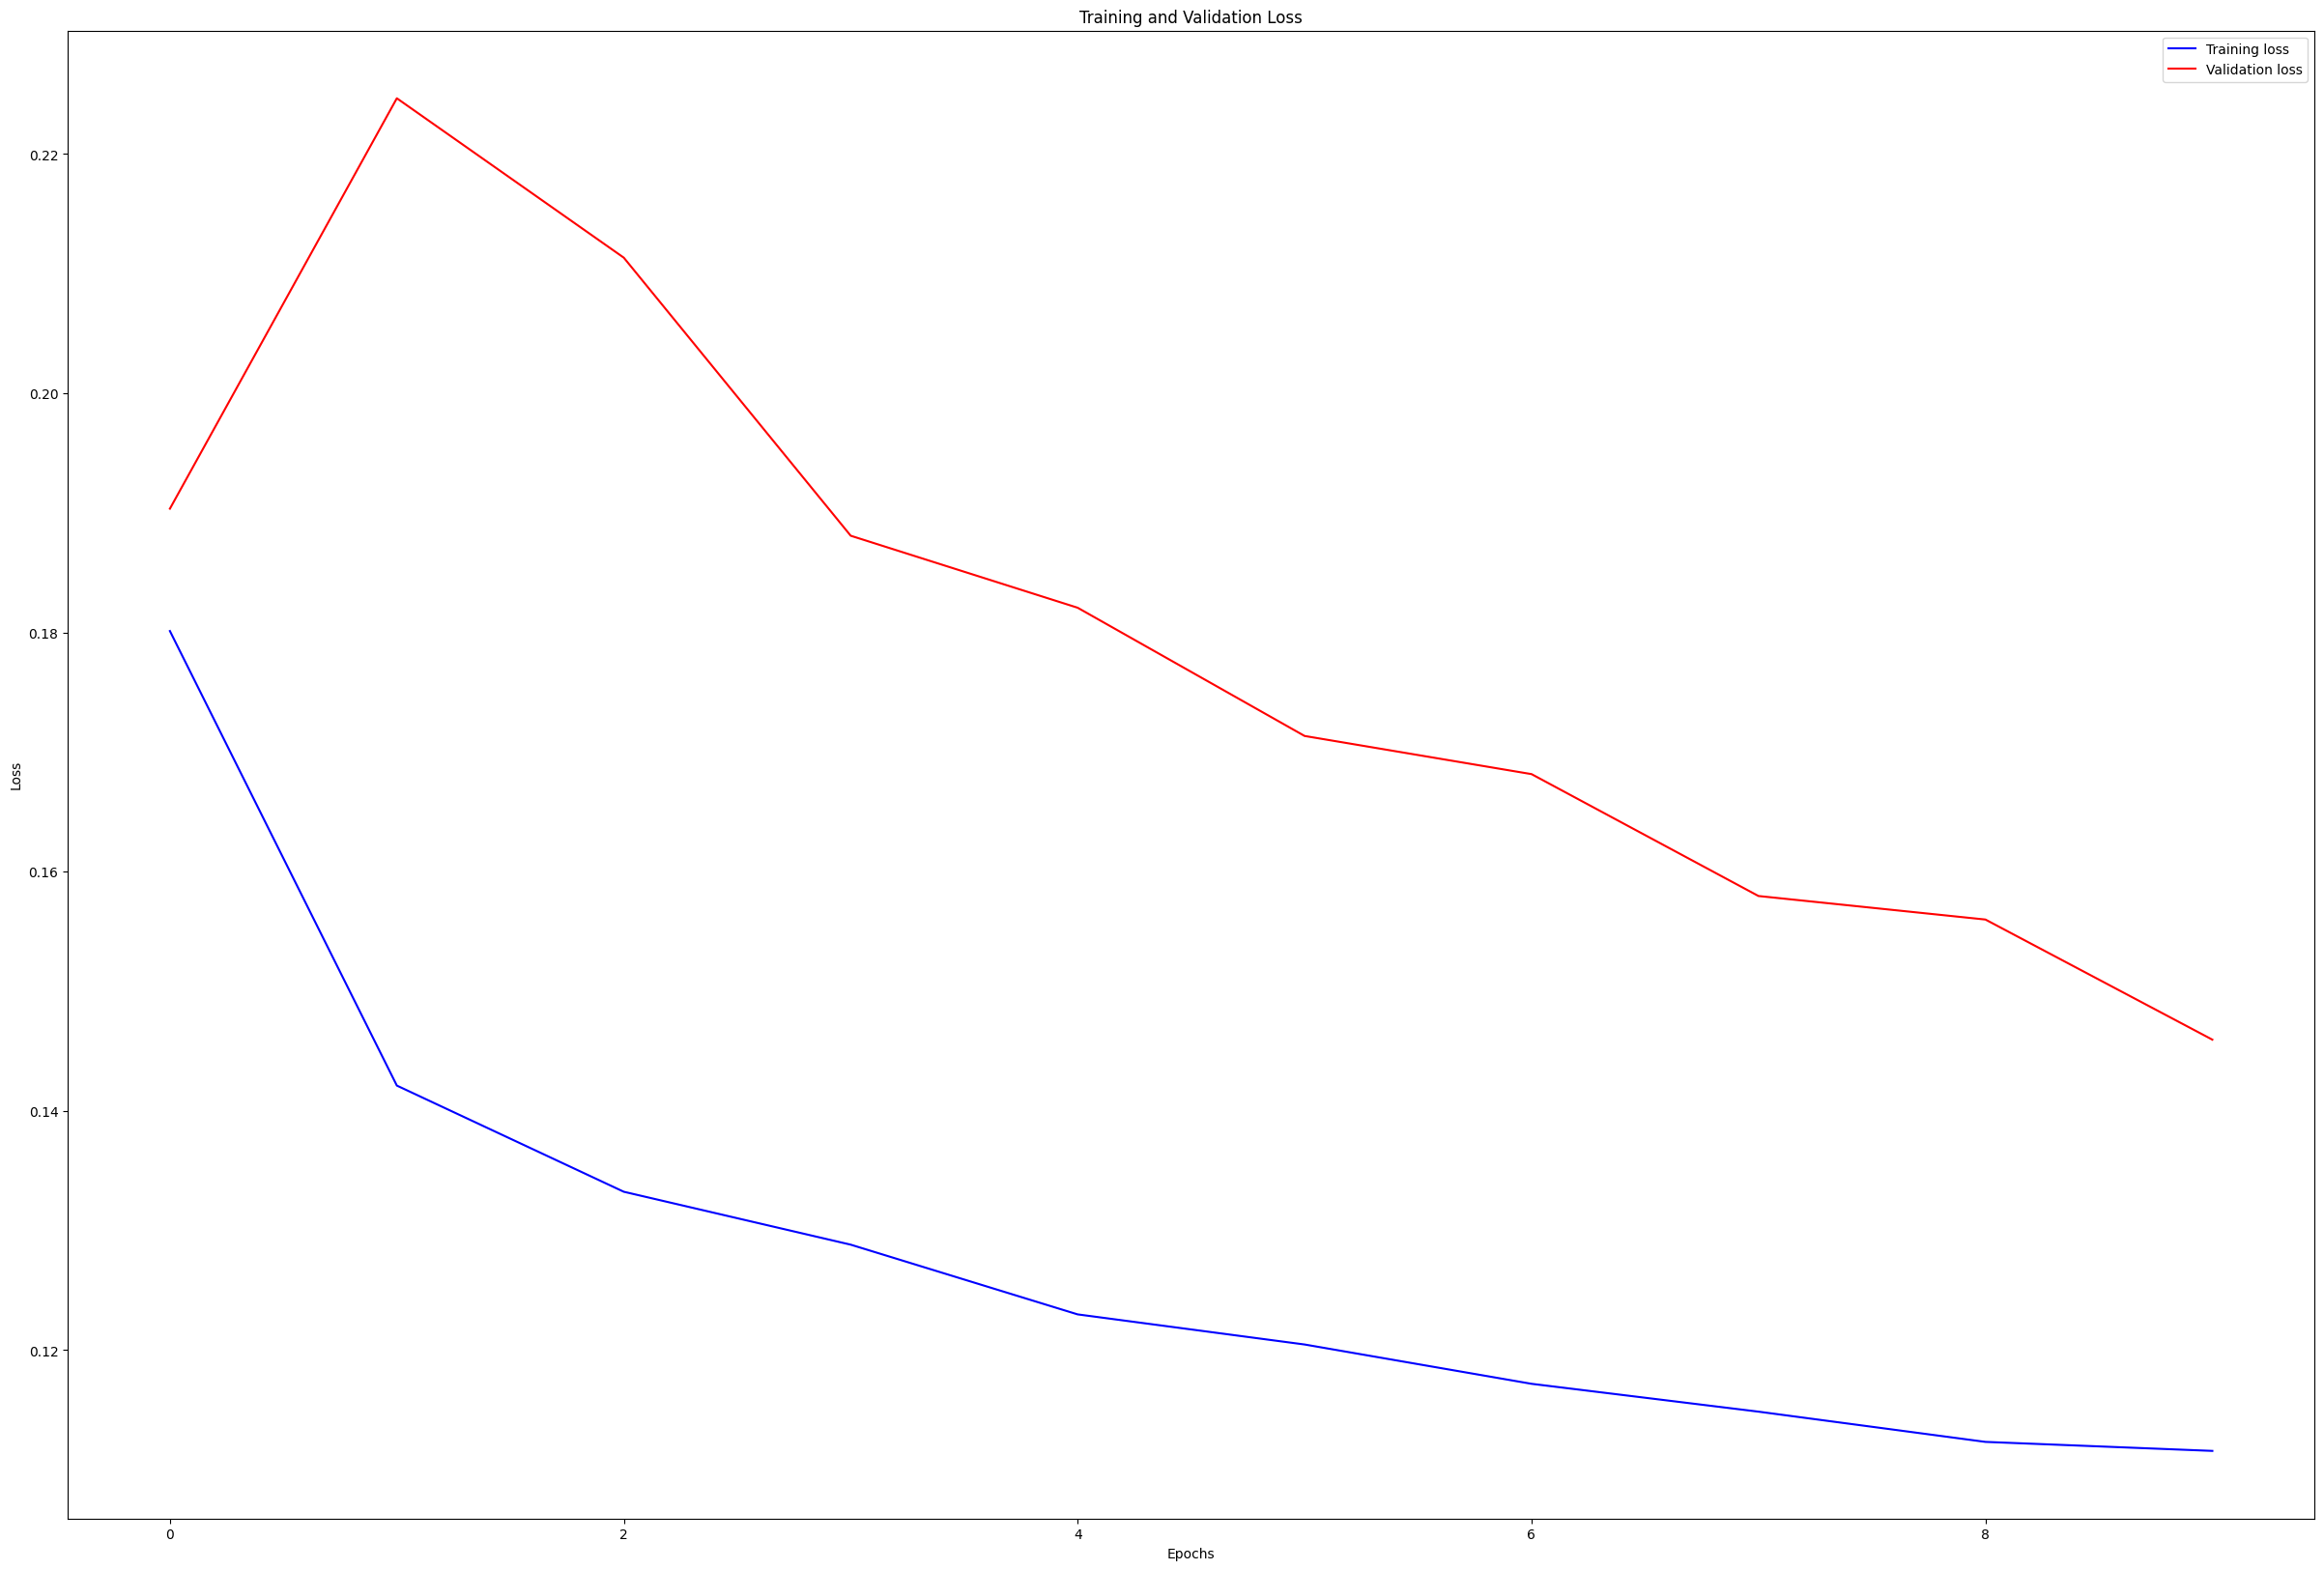

Final val loss:  [0.1903492957353592, 0.2246609479188919, 0.21133609116077423, 0.1880888193845749, 0.18206904828548431, 0.1713491678237915, 0.1681593805551529, 0.15796884894371033, 0.1560021936893463, 0.14595988392829895]
Epoch 1/10
1312/1312 [==============================] - 17s 12ms/step - loss: 0.1779 - val_loss: 0.1895
Epoch 2/10
1312/1312 [==============================] - 15s 11ms/step - loss: 0.1496 - val_loss: 0.2263
Epoch 3/10
1312/1312 [==============================] - 15s 11ms/step - loss: 0.1381 - val_loss: 0.2185
Epoch 4/10
1312/1312 [==============================] - 15s 11ms/step - loss: 0.1329 - val_loss: 0.1916
Epoch 5/10
1312/1312 [==============================] - 15s 11ms/step - loss: 0.1293 - val_loss: 0.1813
Epoch 6/10
1312/1312 [==============================] - 15s 11ms/step - loss: 0.1254 - val_loss: 0.1707
Epoch 7/10
1312/1312 [==============================] - 15s 11ms/step - loss: 0.1216 - val_loss: 0.1625
Epoch 8/10
1312/1312 [============================

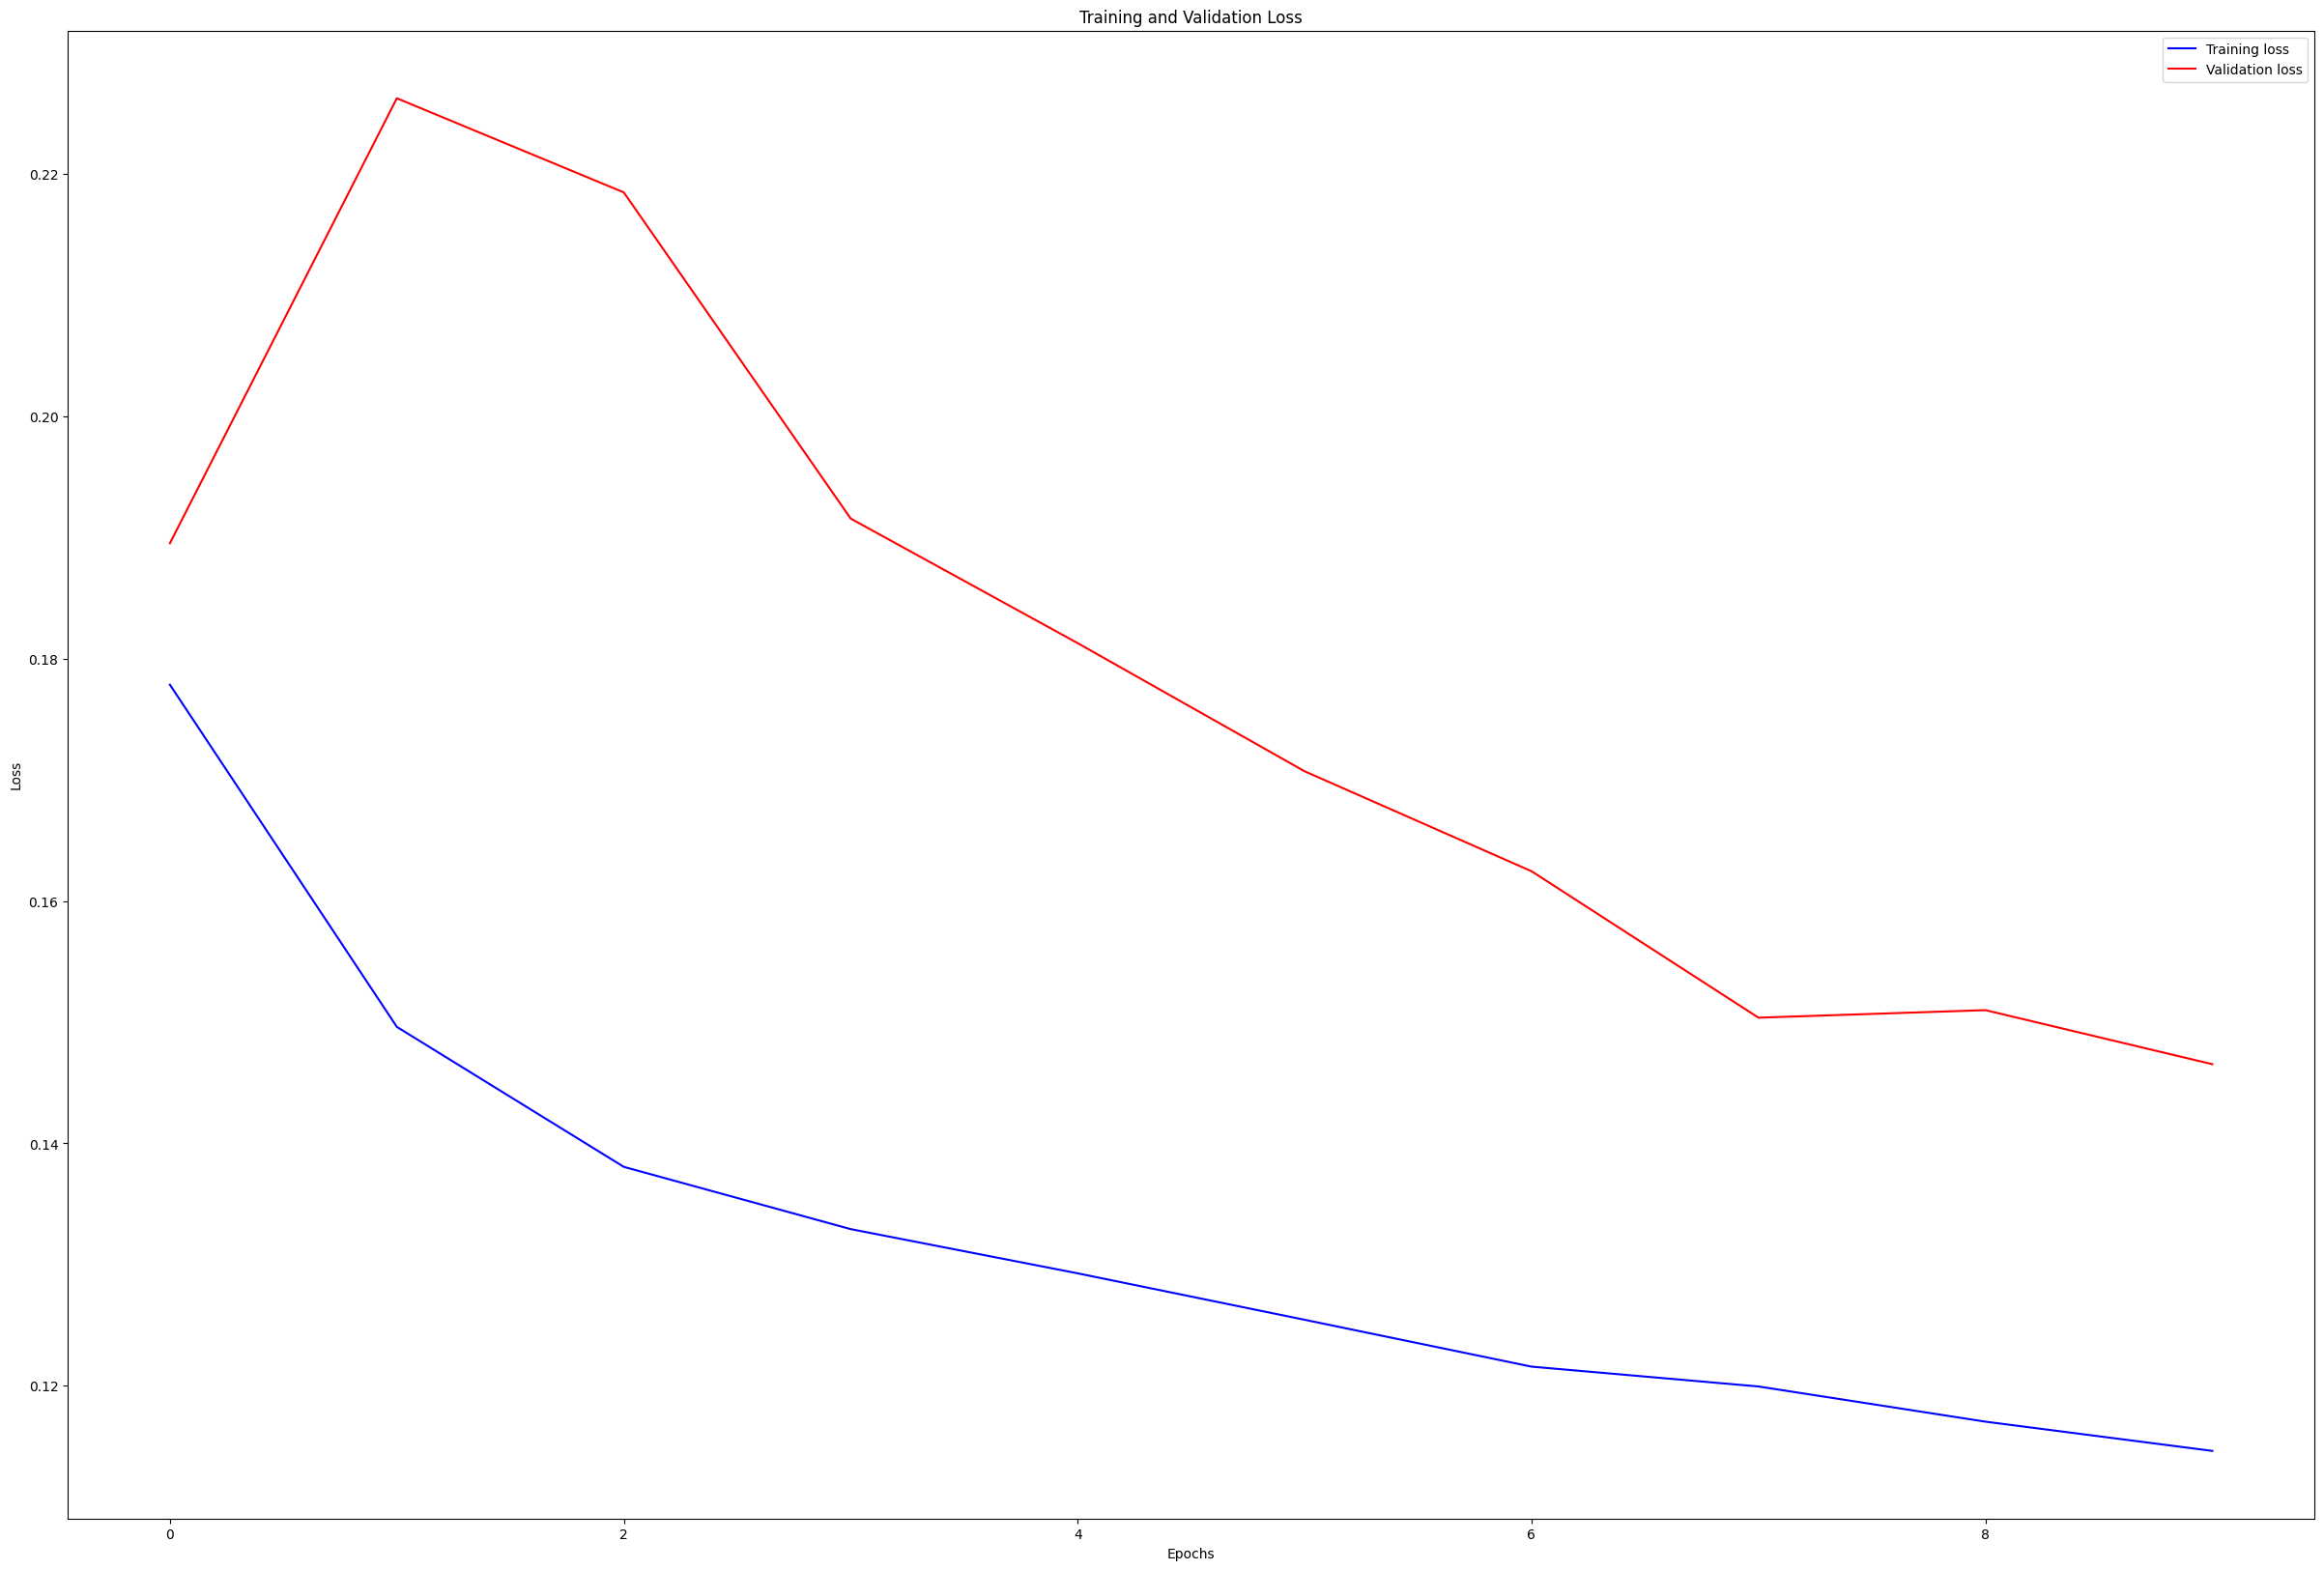

Final val loss:  [0.18953357636928558, 0.2262602597475052, 0.21849386394023895, 0.1915682852268219, 0.18129025399684906, 0.1707139015197754, 0.16246293485164642, 0.15037670731544495, 0.15099789202213287, 0.14653657376766205]
Epoch 1/10
1312/1312 [==============================] - 17s 12ms/step - loss: 0.1917 - val_loss: 0.1805
Epoch 2/10
1312/1312 [==============================] - 15s 11ms/step - loss: 0.1699 - val_loss: 0.2234
Epoch 3/10
1312/1312 [==============================] - 15s 12ms/step - loss: 0.1531 - val_loss: 0.2434
Epoch 4/10
1312/1312 [==============================] - 16s 12ms/step - loss: 0.1449 - val_loss: 0.2221
Epoch 5/10
1312/1312 [==============================] - 15s 12ms/step - loss: 0.1372 - val_loss: 0.1959
Epoch 6/10
1312/1312 [==============================] - 15s 12ms/step - loss: 0.1332 - val_loss: 0.1790
Epoch 7/10
1312/1312 [==============================] - 15s 12ms/step - loss: 0.1298 - val_loss: 0.1791
Epoch 8/10
1312/1312 [=========================

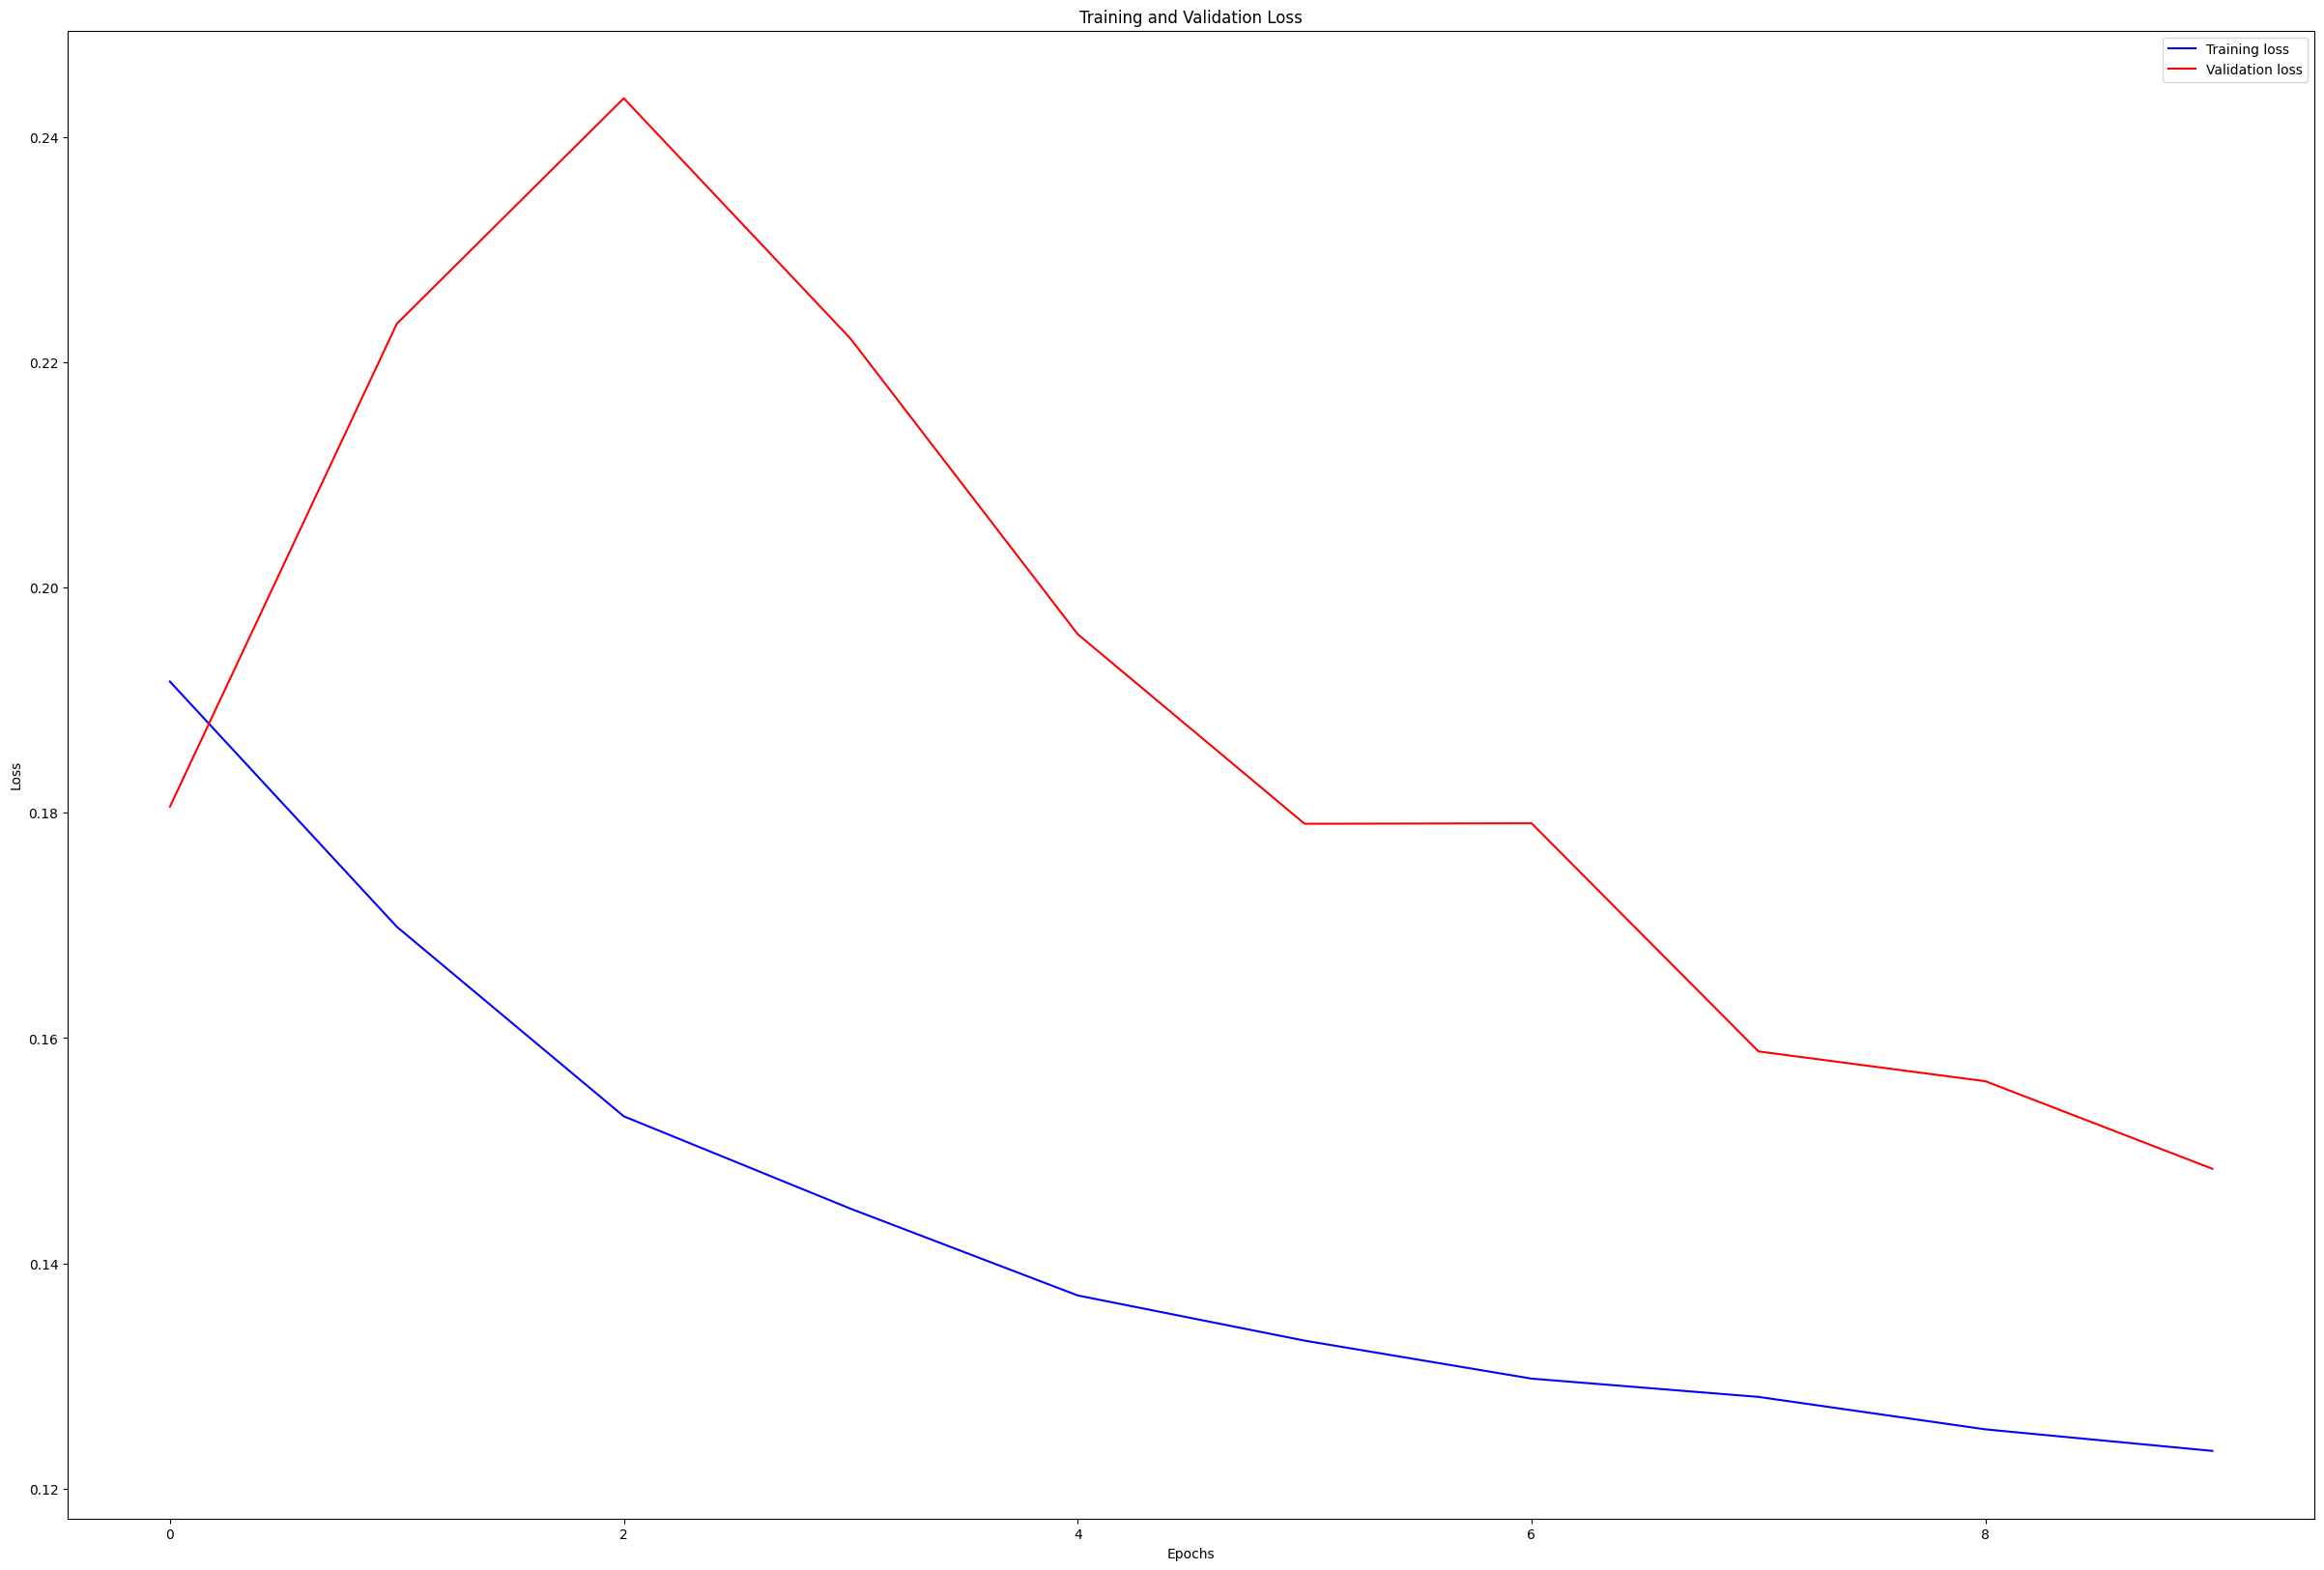

Final val loss:  [0.18053662776947021, 0.22340793907642365, 0.24341541528701782, 0.2220572680234909, 0.19585564732551575, 0.17902447283267975, 0.17906883358955383, 0.15881960093975067, 0.15617404878139496, 0.14840565621852875]
Epoch 1/10
1312/1312 [==============================] - 23s 16ms/step - loss: 0.1765 - val_loss: 0.2154
Epoch 2/10
1312/1312 [==============================] - 21s 16ms/step - loss: 0.1554 - val_loss: 0.2152
Epoch 3/10
1312/1312 [==============================] - 21s 16ms/step - loss: 0.1404 - val_loss: 0.2410
Epoch 4/10
1312/1312 [==============================] - 21s 16ms/step - loss: 0.1318 - val_loss: 0.2176
Epoch 5/10
1312/1312 [==============================] - 21s 16ms/step - loss: 0.1257 - val_loss: 0.1727
Epoch 6/10
1312/1312 [==============================] - 21s 16ms/step - loss: 0.1200 - val_loss: 0.1844
Epoch 7/10
1312/1312 [==============================] - 21s 16ms/step - loss: 0.1176 - val_loss: 0.1695
Epoch 8/10
1312/1312 [=======================

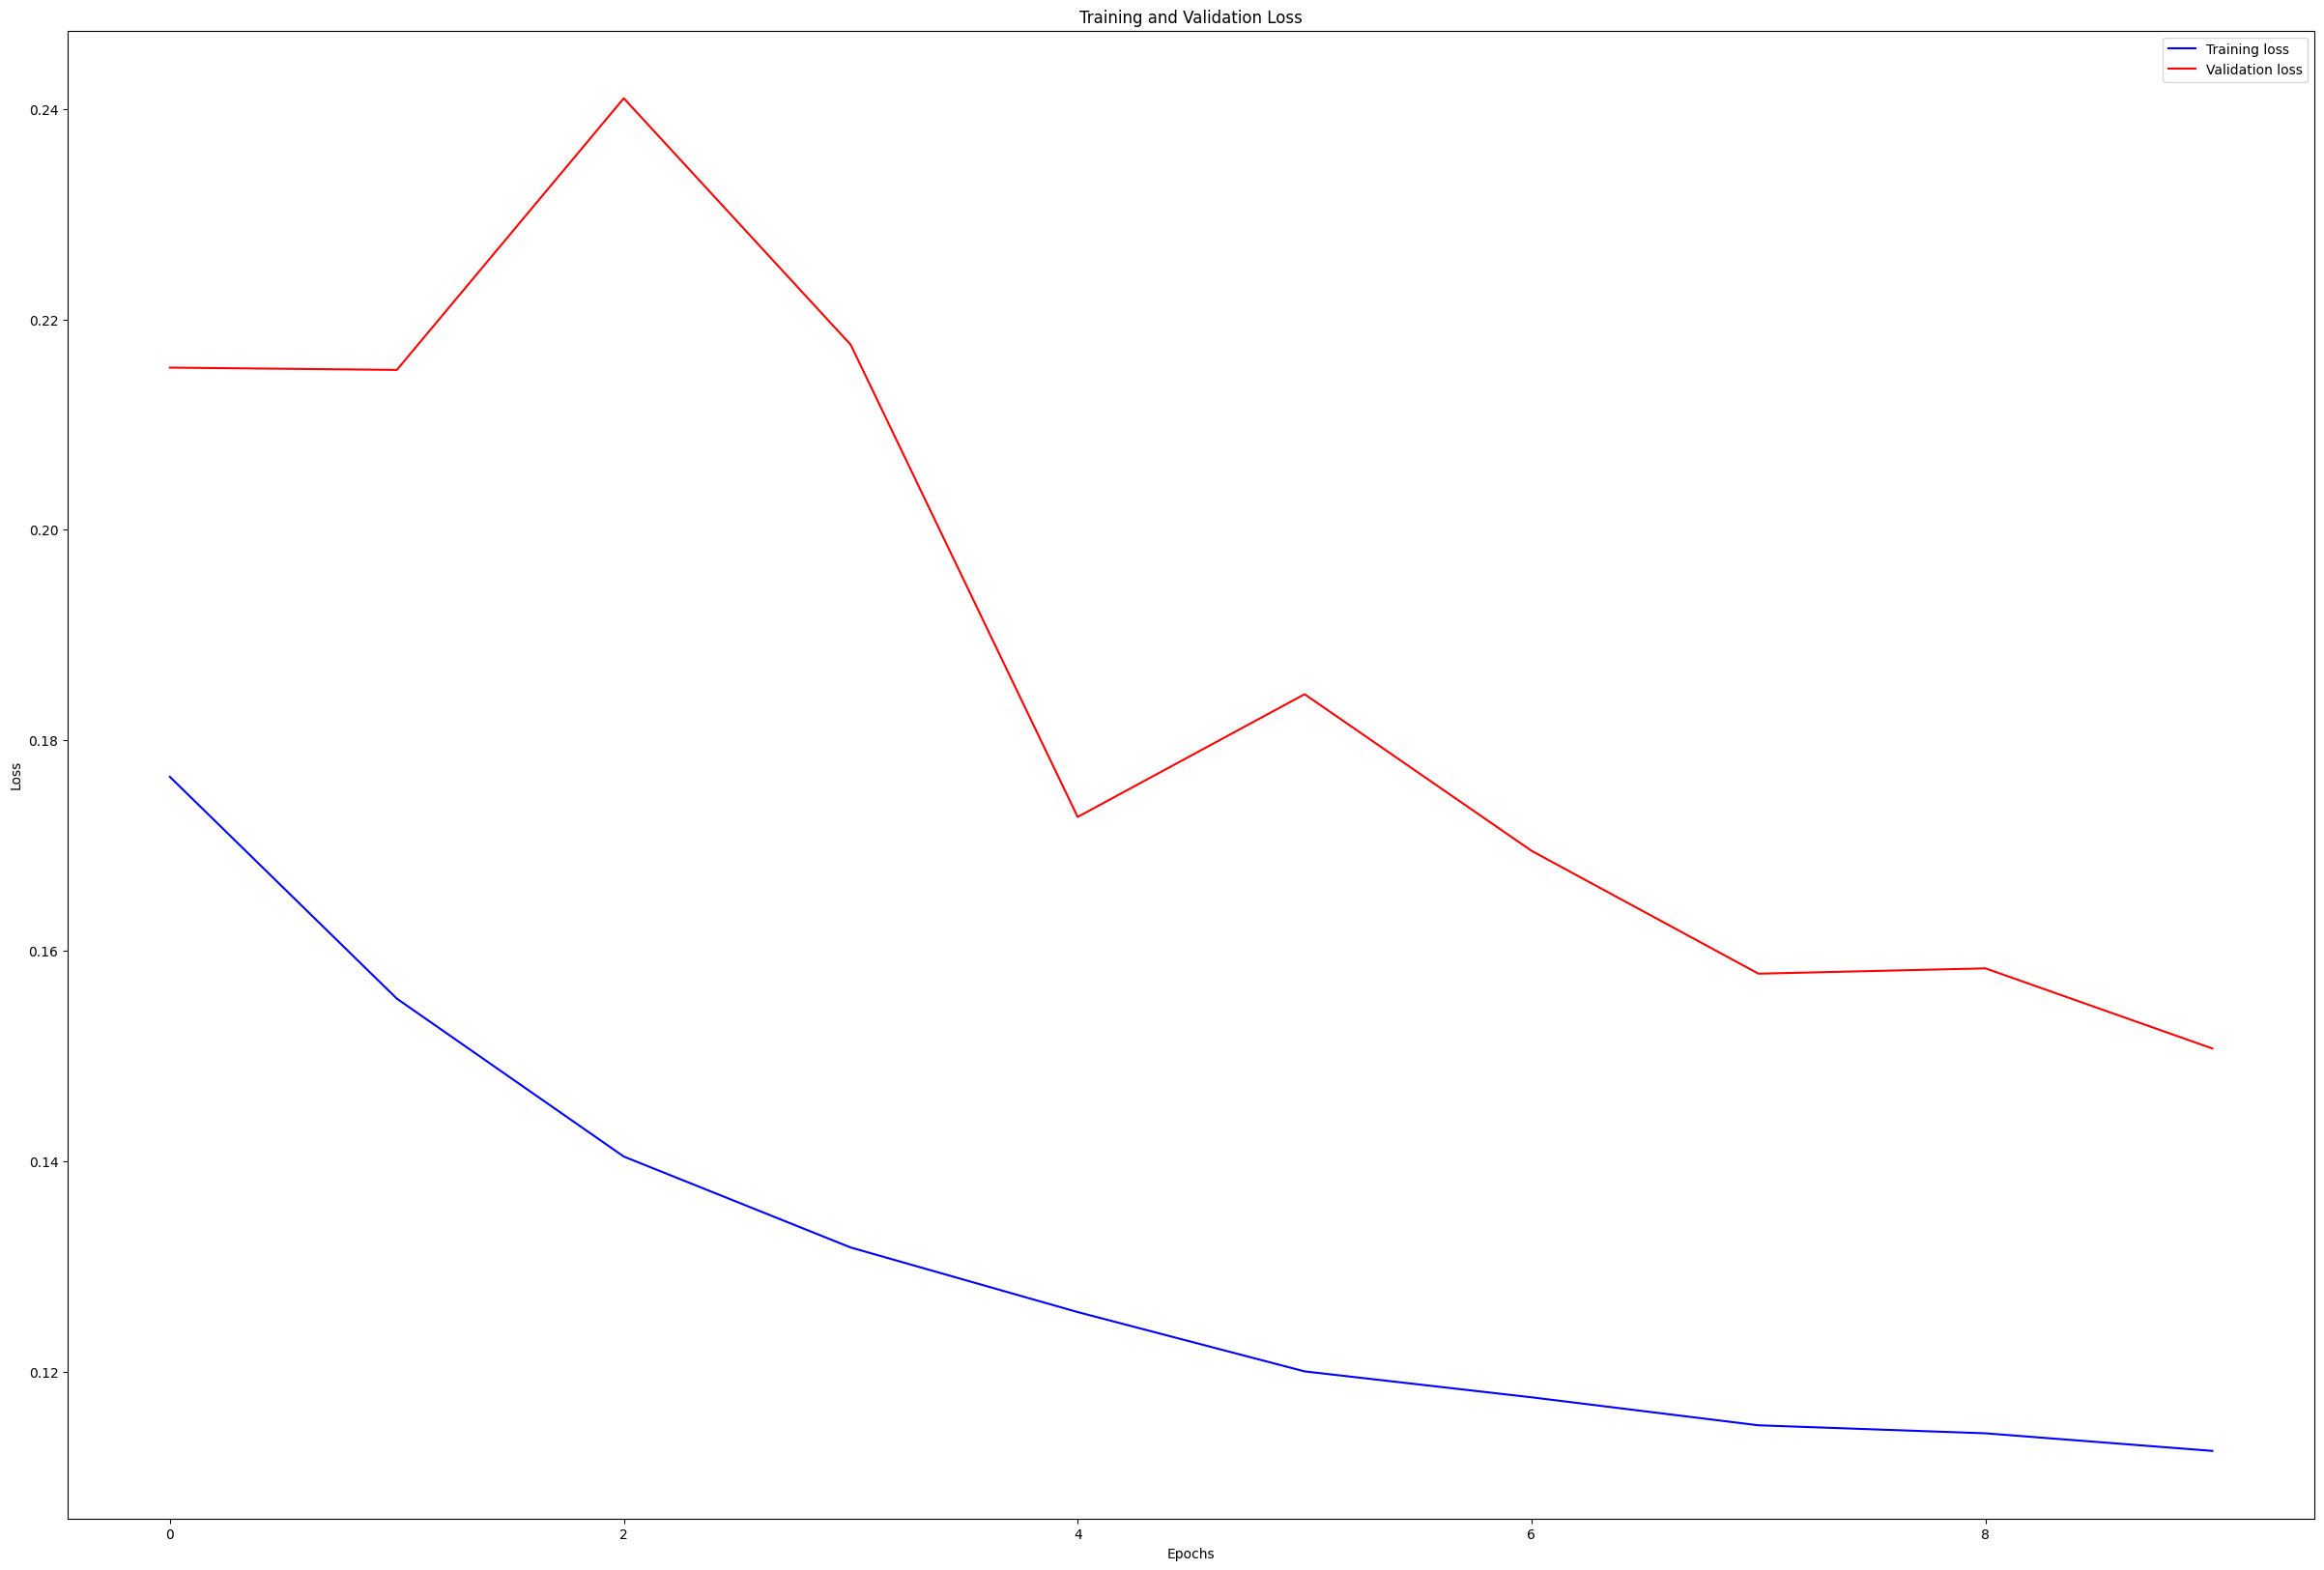

Final val loss:  [0.2154160588979721, 0.2151978462934494, 0.24101415276527405, 0.21758821606636047, 0.17270976305007935, 0.18437547981739044, 0.16949282586574554, 0.15781359374523163, 0.15832015872001648, 0.1507043093442917]
Epoch 1/10
1312/1312 [==============================] - 23s 17ms/step - loss: 0.1804 - val_loss: 0.1899
Epoch 2/10
1312/1312 [==============================] - 21s 16ms/step - loss: 0.1586 - val_loss: 0.2172
Epoch 3/10
1312/1312 [==============================] - 21s 16ms/step - loss: 0.1463 - val_loss: 0.2198
Epoch 4/10
1312/1312 [==============================] - 22s 16ms/step - loss: 0.1352 - val_loss: 0.2100
Epoch 5/10
1312/1312 [==============================] - 22s 16ms/step - loss: 0.1298 - val_loss: 0.1837
Epoch 6/10
1312/1312 [==============================] - 21s 16ms/step - loss: 0.1233 - val_loss: 0.1772
Epoch 7/10
1312/1312 [==============================] - 21s 16ms/step - loss: 0.1213 - val_loss: 0.1733
Epoch 8/10
1312/1312 [=========================

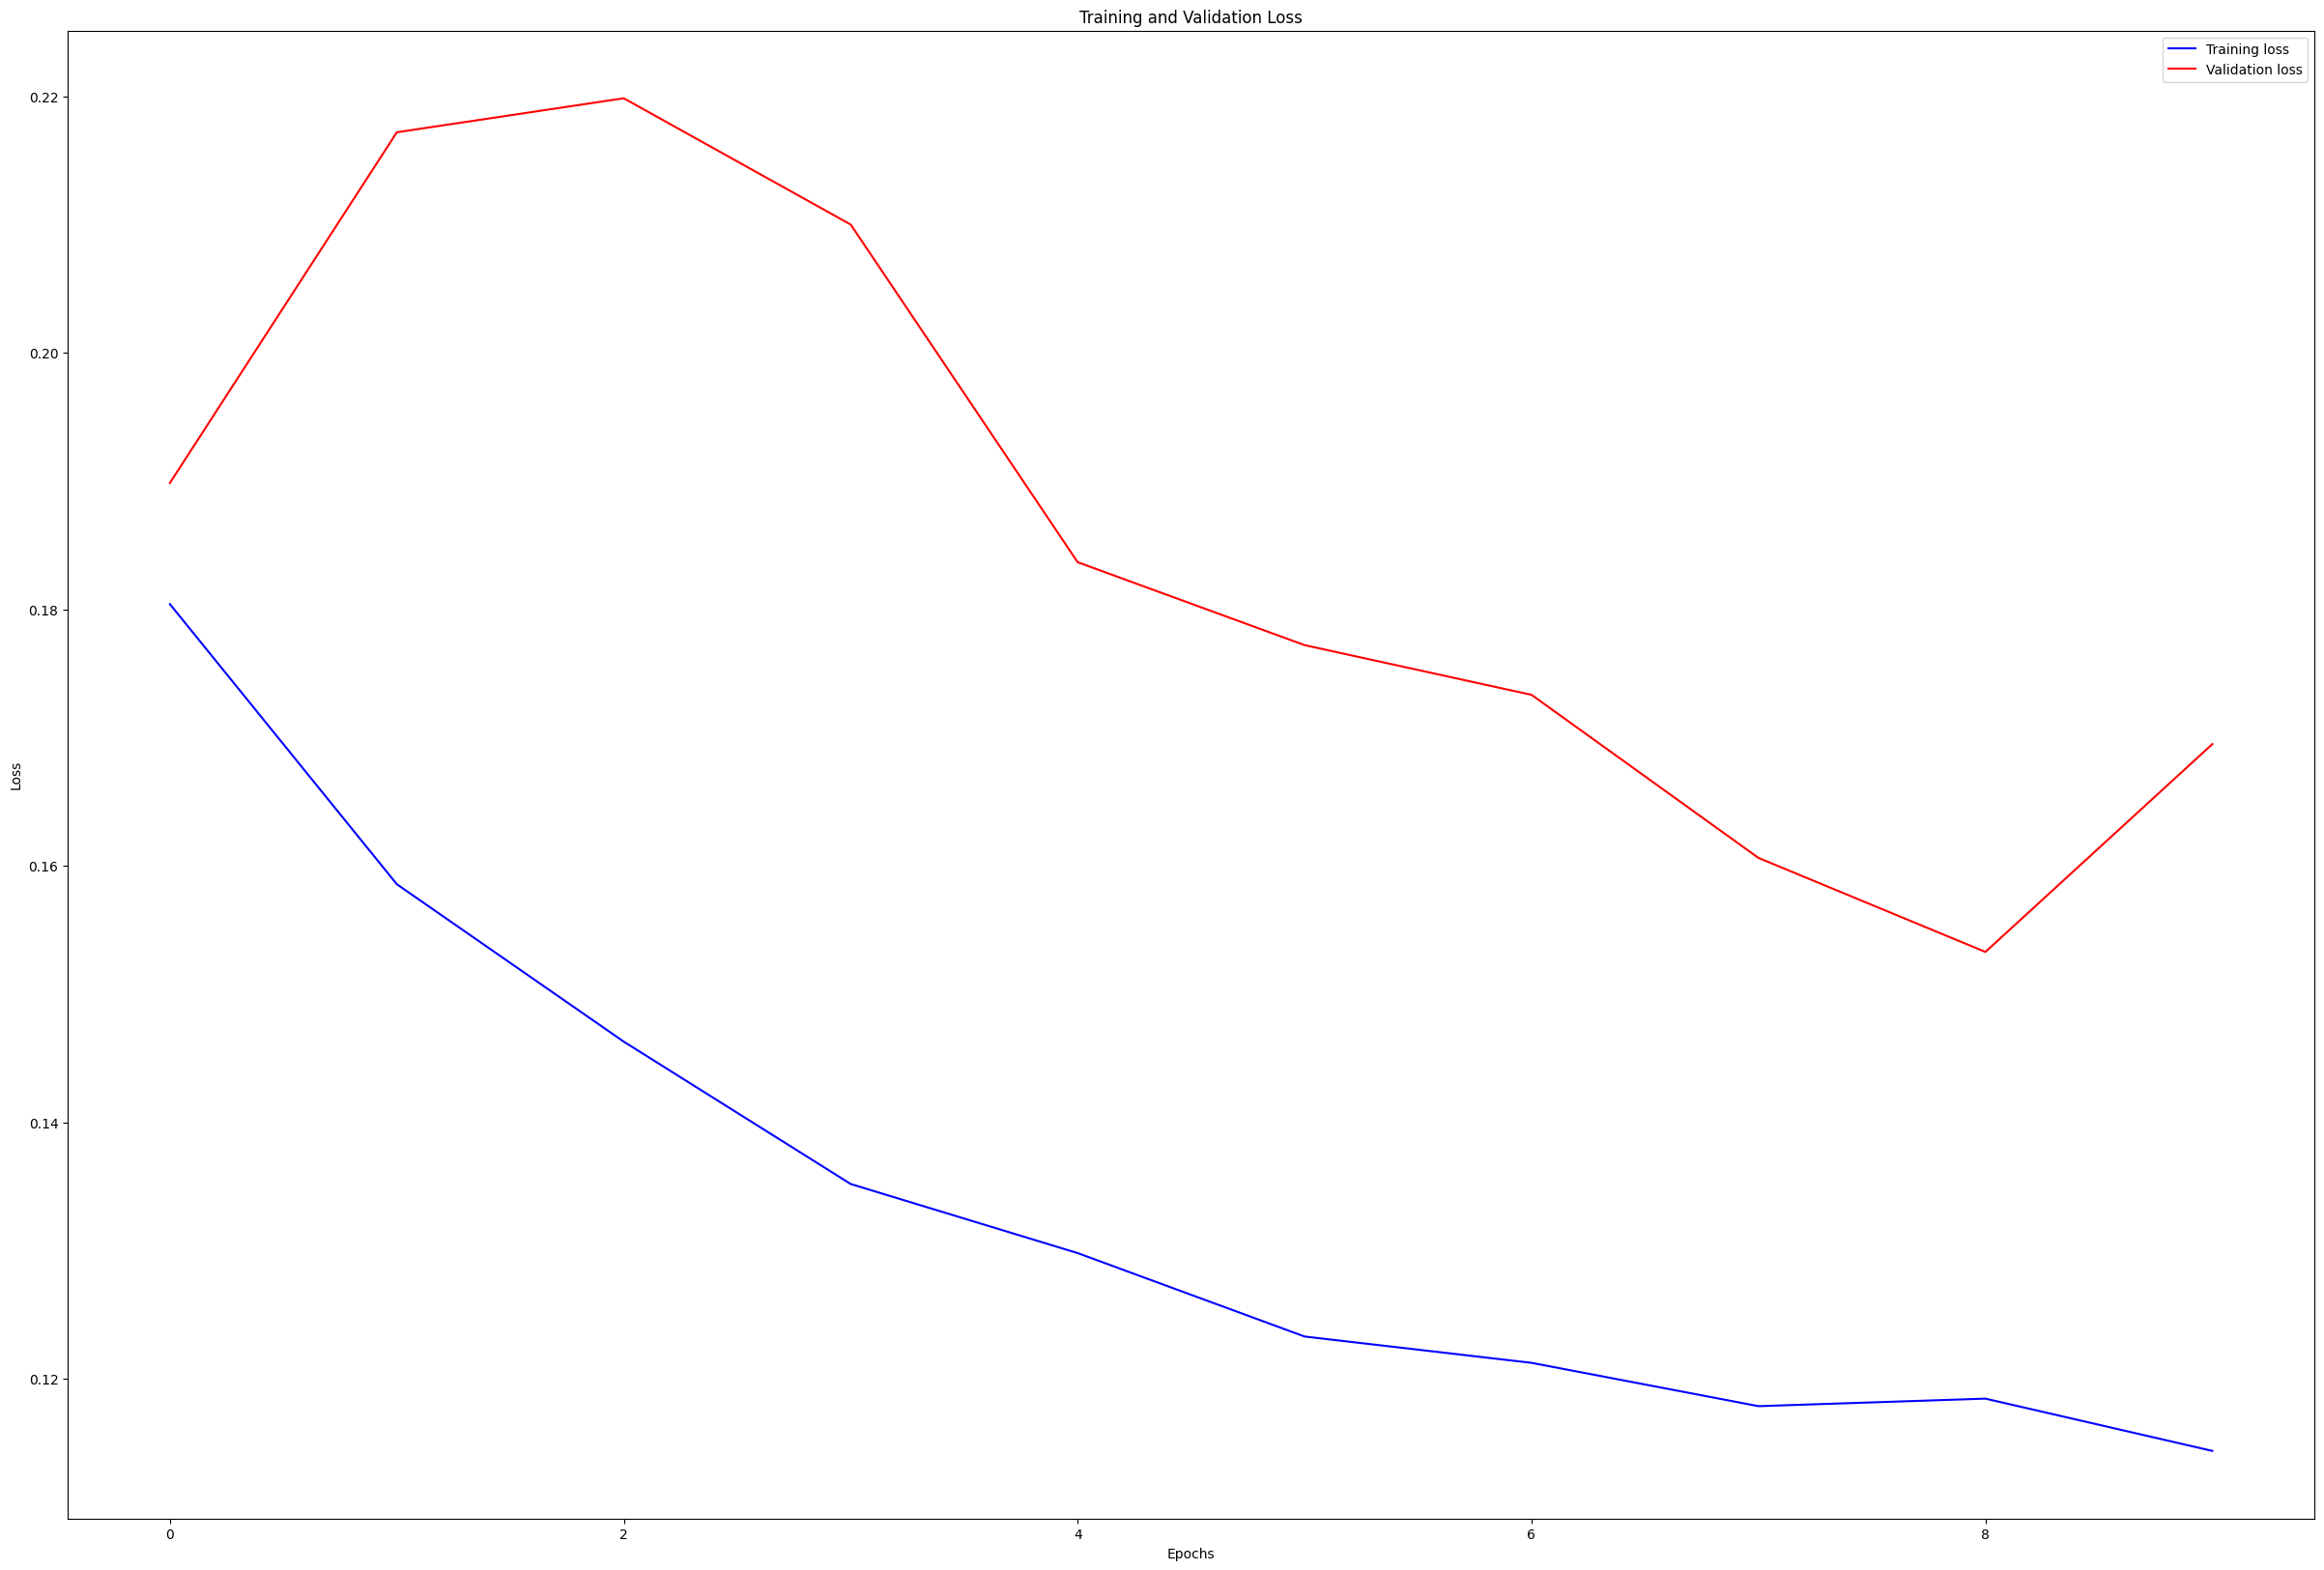

Final val loss:  [0.1898529827594757, 0.21718764305114746, 0.2198374718427658, 0.2099936306476593, 0.18367493152618408, 0.17721113562583923, 0.1733369529247284, 0.16062365472316742, 0.1532963514328003, 0.1694958359003067]
Epoch 1/10
1312/1312 [==============================] - 24s 17ms/step - loss: 0.2043 - val_loss: 0.1963
Epoch 2/10
1312/1312 [==============================] - 22s 16ms/step - loss: 0.1658 - val_loss: 0.1739
Epoch 3/10
1312/1312 [==============================] - 22s 16ms/step - loss: 0.1431 - val_loss: 0.2243
Epoch 4/10
1312/1312 [==============================] - 23s 18ms/step - loss: 0.1367 - val_loss: 0.2207
Epoch 5/10
1312/1312 [==============================] - 22s 16ms/step - loss: 0.1291 - val_loss: 0.1860
Epoch 6/10
1312/1312 [==============================] - 21s 16ms/step - loss: 0.1292 - val_loss: 0.1860
Epoch 7/10
1312/1312 [==============================] - 21s 16ms/step - loss: 0.1232 - val_loss: 0.1672
Epoch 8/10
1312/1312 [============================

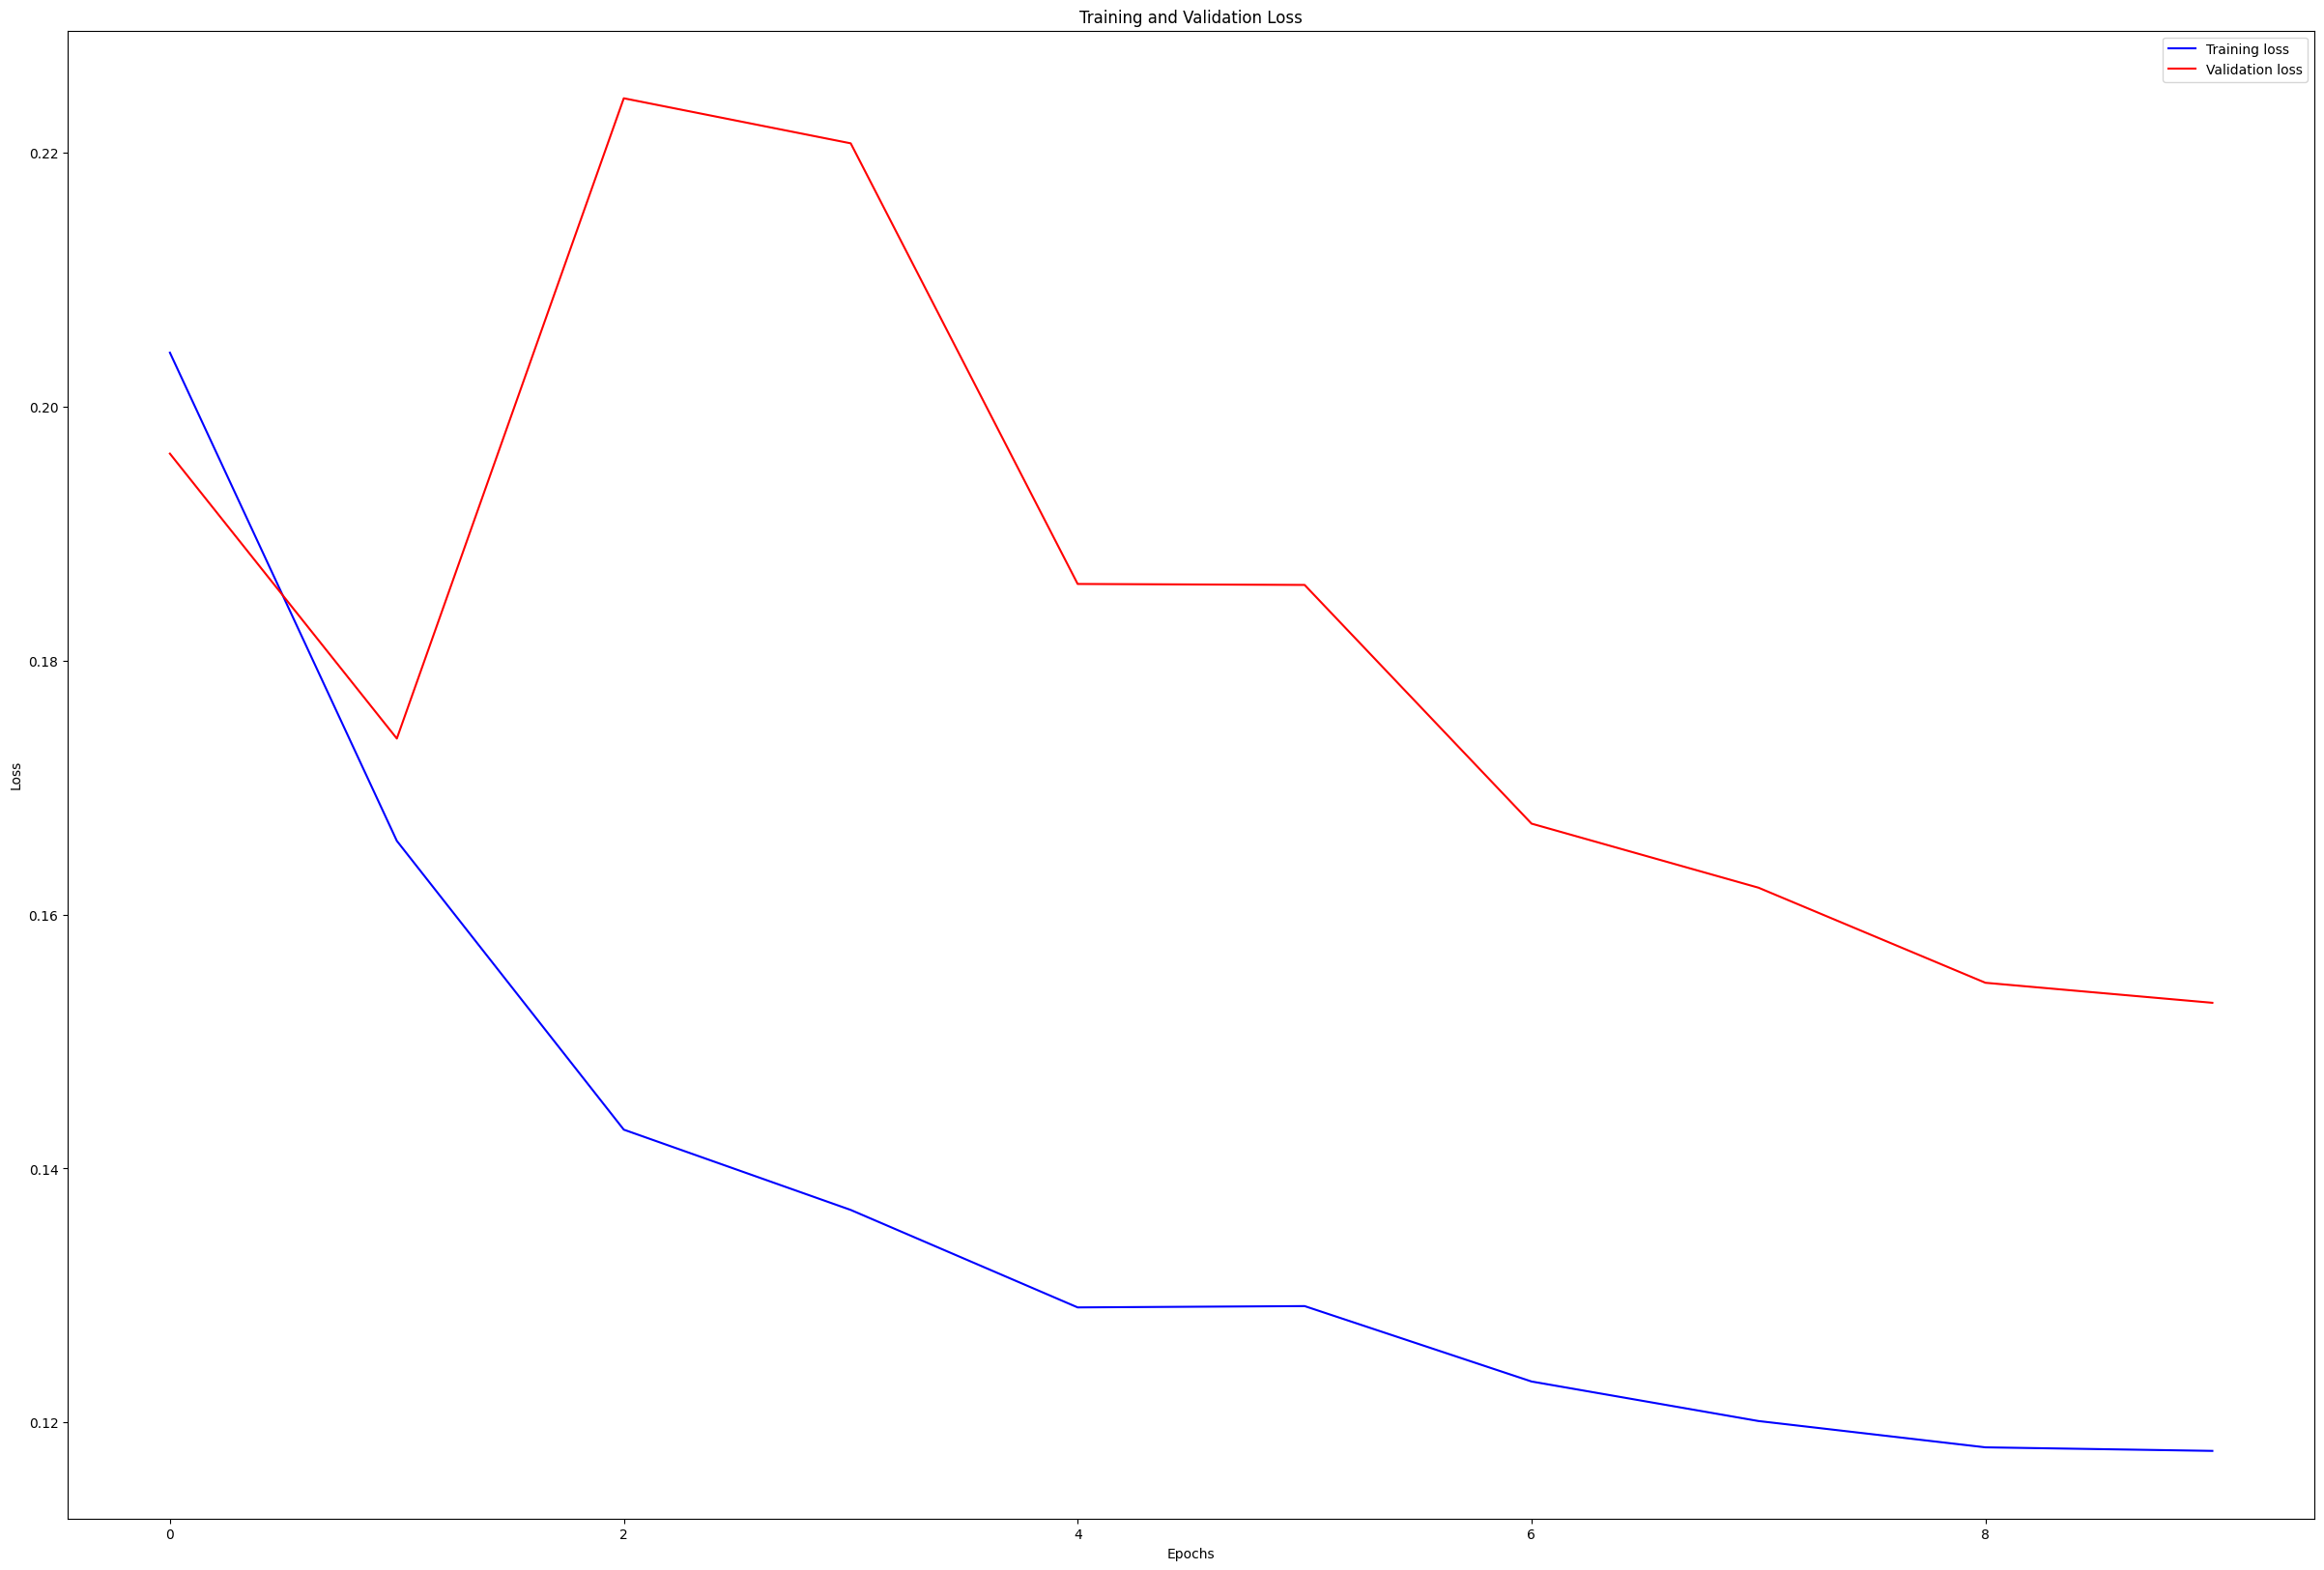

Final val loss:  [0.19630159437656403, 0.17386233806610107, 0.2242903858423233, 0.22074206173419952, 0.18603835999965668, 0.18596172332763672, 0.16716207563877106, 0.16211621463298798, 0.15462765097618103, 0.15305106341838837]


In [25]:
for nodes in nodes_values:
  for dropout in dropouts:
    inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
    lstm_out = keras.layers.LSTM(nodes)(inputs)
    if dropout != 0:
      lstm_out = keras.layers.Dropout(dropout)(lstm_out)
    outputs = keras.layers.Dense(1)(lstm_out)

    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss='mse')
    path_checkpoint = "model_checkpoint.h5"
    es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

    modelckpt_callback = keras.callbacks.ModelCheckpoint(
      monitor="val_loss",
      filepath=path_checkpoint,
      verbose=0,
      save_weights_only=True,
      save_best_only=True,
    )

    history = model.fit(
      dataset_train,
      epochs=epochs,
      validation_data=dataset_val,
      callbacks=[es_callback, modelckpt_callback],
    )
    print("Results for ", nodes, dropout)
    results = model.evaluate(dataset_test, batch_size=batch_size)
    visualize_loss(history, "Training and Validation Loss")


With 32 nodes min val loss: 0.1442 @ 32 0.2

With 64 nodes, Min val loss: 0.1419 @ 64 0.2

With 128 nodes, 0.145959 @ 128 0.2

With 256 nodes, 0.15 @ 256 0.2

It seemed as though dropout beyond 0.2 was not meaningful and didn't improve performance, and our best results were at 64 nodes. Below that was underfitting, and over that was overfitting.